This latest version of the code provides a number of new effects.
1.  $\bf{DM\to \Delta f_\gamma}$. DM energy injection produces low energy photons that contribute to the blackbody distortion.
2.  $\bf{f_{exc,nl}\to \Delta f_\gamma}$. Some of that energy excites hydrogen atoms to the $nl$ excited state. These atoms then transition through many other excited states, producing or absorbing line photons that contribute to the distortion.
3.  $\bf{f_{exc,nl}\to \dot{x}_e}$. Sometimes these excited state transitions end in an ionization.
{4.  $\bf{f_{ion}\to \Delta f_\gamma}$. Extra ionization means extra photon absorption, and also an increase in recombinations, both of which affect the distortion.}
5. $\bf{\Delta f_\gamma \to \dot{x}_e}$. All rates -- recombination, ionization, and atomic transitions -- depend on the photon phase space density.  When $\Delta f_\gamma$ is non-zero, the rates change, and the ionization rate changes.
6. $\bf{\Delta f_\gamma \to \Delta f_\gamma}$. The distortion can be reprocessed over time, e.g. photons that are emitted at early times can be absorbed at later times.

In [433]:
import sys
sys.path.append('../..')

import config
import main
import pickle

import numpy as np
from tqdm import tqdm_notebook as tqdm
from scipy.interpolate import interp1d, interp2d

import darkhistory.physics as phys
from darkhistory.spec.spectra import Spectra
from darkhistory.spec.spectrum import Spectrum
import darkhistory.low_energy.atomic as atomic
import darkhistory.spec.spectools as spectools

In [330]:
import csv

def download_plot(file):
    with open('/Users/gregoryridgway/Desktop/Webplot_distortion/'+file+'.csv') as csvfile:
        reader = csv.reader(csvfile)
        goods = []
        for row in reader:
            goods.append([float(r) for r in row])
            
        goods = np.array(goods)

    return goods

n10_data = download_plot('n10')
n20_data = download_plot('n20')
n30_data = download_plot('n30')
jens_data = download_plot('Full_Distortion')
jens_2s = download_plot('DeltaR_2s_jens')
jens_2p = download_plot('DeltaR_2p_jens')
BB_BF_jens = download_plot('BB_plus_BF_dist')

# Data from Jens Chluba et al's papers
# plt.plot(BB_BF_jens[:,0], BB_BF_jens[:,1], color='k',
#          linewidth=1.2, label='Chluba+Sunyaev', alpha=0.6)
# plt.plot(n10_data[:,0], n10_data[:,1], color='k',
#          linewidth=2.0, linestyle='--', label='Jens+')
# plt.plot(n20_data[:,0], n20_data[:,1], color='k', linewidth=1.0, linestyle=':')
# plt.plot(n30_data[:,0], n30_data[:,1], color='k', linewidth=1.2)
# plt.plot(jens_data[:,0], jens_data[:,1], color='k', linewidth=2.0, linestyle='--')

In [331]:
%autoreload
def Gy(nu):
    return phys.ymu_distortion(nu, 1/4, phys.TCMB(1) / phys.kB, dist_type='y')

def y_dist_test(nu, result, mDM, lifetime, coarsen_factor=1):
    rs_list = result['rs']
    
    # nu is the frequencies in Hz over which to calculate the distortion
    weights = result['f']['heat'] * phys.inj_rate('decay', rs_list,
                                                  mDM=mDM, lifetime=lifetime)
    weights /= phys.CMB_eng_density(phys.TCMB(rs_list))
    
    weights[rs_list < 100] = 0
    return (
        Gy(nu) # Green's function
        * np.sum(weights * .001 * coarsen_factor / phys.hubble(rs_list)) # integrate over redshift
        * 1e4 * phys.ele # units of W / m^2 / ster / Hname
    )

# data1 = (
#     y_dist_test(nu, DM_run_withf, mDM, lifetime, coarsen_factor)
# )

In [332]:
from scipy.interpolate import interp2d
input_dir = config.data_path

decay_elec_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_elec_decay.csv', delimiter=',')
decay_elec_CMB = interp1d(np.transpose(decay_elec_CMB_raw)[0,:], np.transpose(decay_elec_CMB_raw)[1,:])

f_elec_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_elec_swave.dat', delimiter=',')
log10eng_elec_CMB  = f_elec_CMB_raw[0:2760:69, 0]
log10rs_elec_CMB = f_elec_CMB_raw[0:69, 1]

f_phot_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_phot_swave.dat', delimiter=',')
log10eng_phot_CMB  = f_phot_CMB_raw[0:2800:70, 0]
log10rs_phot_CMB = f_phot_CMB_raw[0:70, 1]

f_elec_CMB_raw = np.transpose(np.reshape(f_elec_CMB_raw[:,2], (40,69)))
f_phot_CMB_raw = np.transpose(np.reshape(f_phot_CMB_raw[:,2], (40,70)))

f_elec_CMB = interp2d(log10eng_elec_CMB, log10rs_elec_CMB, f_elec_CMB_raw)
f_phot_CMB = interp2d(log10eng_phot_CMB, log10rs_phot_CMB, f_phot_CMB_raw)

decay_elec_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_elec_decay.csv', delimiter=',')
decay_phot_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_phot_decay.csv', delimiter=',')

decay_elec_CMB = interp1d(np.transpose(decay_elec_CMB_raw)[0,:], np.transpose(decay_elec_CMB_raw)[1,:])
decay_phot_CMB = interp1d(np.transpose(decay_phot_CMB_raw)[0,:], np.transpose(decay_phot_CMB_raw)[1,:])

decay_elec_CMB_raw = np.loadtxt(config.data_path+'/CMB_limits_elec_decay.csv', delimiter=',')
decay_elec_CMB = interp1d(np.transpose(decay_elec_CMB_raw)[0,:], np.transpose(decay_elec_CMB_raw)[1,:])

#Derived from Planck 2018 cosmological parameters
p_ann = 3.5e-28

def param_bound_elec_CMB(mDM, DM_process):
    if DM_process == 'swave':
        return p_ann*(mDM*1e-9)/f_elec_CMB(np.log10(mDM-phys.me), np.log10(601))[0]
    elif DM_process == 'decay':
        return np.array([decay_elec_CMB(mDM*1e-9)])[0]

def param_bound_phot_CMB(mDM, DM_process):
    if DM_process == 'swave':
        return p_ann*(mDM*1e-9)/f_phot_CMB(np.log10(mDM), np.log10(601))[0]
    elif DM_process == 'decay':
        return np.array([decay_phot_CMB(mDM*1e-9)])[0]
    
def param_bound(mDM, DM_process, pri):
    if pri == 'elec':
        return param_bound_elec_CMB(mDM, DM_process)
    else:
        return param_bound_phot_CMB(mDM, DM_process)

# 1. Distortion, DM component

In [323]:
%autoreload

pri = 'elec'
DM_process = 'decay'
mDM = 2e8
# mDM = 10**log10eng[::10][1] + phys.me
# mDM = 10**6.5
nmax=10

param = param_bound(mDM, DM_process, pri)
coarsen_factor = 16
string = str(int(np.floor(np.log10(mDM))))
start_rs = 3e3
end_rs = 5

baseline = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=param*1e20,
    sigmav=param,
    primary=pri+'_delta',
    start_rs = start_rs, high_rs = 1.555e3, end_rs=end_rs,
    coarsen_factor=coarsen_factor,
    distort=True, recfast_TLA=True,
    fexc_switch = False, nmax=nmax
)

DMrun = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=param,
    sigmav=param,
    primary=pri+'_delta',
    start_rs = start_rs, high_rs = 1.555e3, end_rs=end_rs,
    coarsen_factor=coarsen_factor,
    distort=True, recfast_TLA=True,
    fexc_switch = False, 
    reprocess_distortion=False, 
    nmax=nmax
)

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:466: RuntimeWarning: overflow encountered in true_divide
  K[nl, states_l == l+1] = BB['dn'][l+2:, n, l+1]/tot_rate
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:470: RuntimeWarning: overflow encountered in double_scalars
  K[0][1] = BB['dn'][2][1][0] / tot_rate
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:466: RuntimeWarning: divide by zero encountered in true_divide
  K[nl, states_l == l+1] = BB['dn'][l+2:, n, l+1]/tot_rate
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:470: RuntimeWarning: divide by zero encountered in double_scalars
  K[0][1] = BB['dn'][2][1][0] / tot_rate
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/D

In [324]:
# spectra of lowengphots
tmp = DMrun['lowengphot'].copy()

# mask out ionizing photons
mask = np.array(list(map(float,tmp.eng<13.6)))
tmp._grid_vals = tmp._grid_vals * mask

# redshift then sum
tmp.redshift(1.)
tmp = tmp.sum_specs()

Text(0, 0.5, 'Intensity, $I_{\\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]')

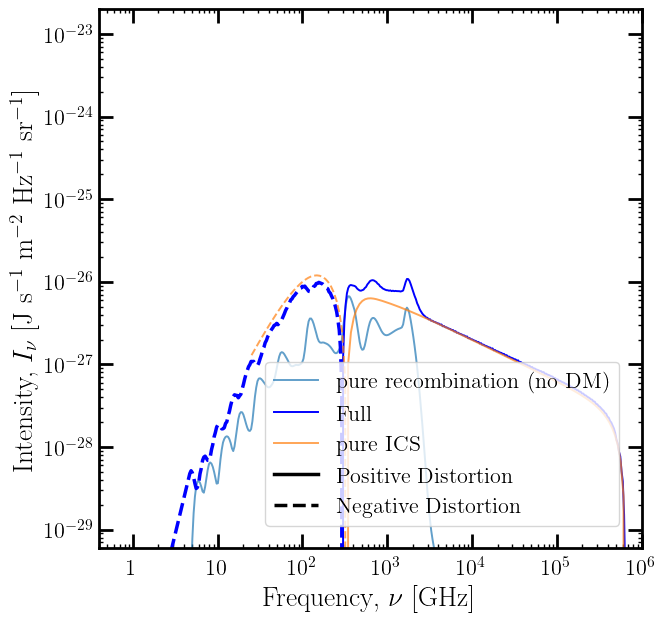

In [325]:
eng = baseline['distortion'].eng

hplanck = phys.hbar * 2*np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck
rs_fac = 1300


plt.figure(figsize=(7, 7))
plt.loglog()
plt.xlim([4e-1, 1e6])
plt.ylim([6e-30, 2e-23])

# DH generated data
plt.plot(nu/1e9, convert * baseline['distortion'].dNdE,
         color='C0', linewidth=1.4, label='pure recombination (no DM)', alpha=0.7)
# plt.plot(nu/1e9, convert * DMrun['distortion'].dNdE,
#          color='blue', linewidth=1.4, label='w/ DM, (+)')
# plt.plot(nu/1e9, -convert * DM_run['distortion'].dNdE,
#          color='red', linewidth=1.4, label='w/ DM, (-)')

plt.plot(nu/1e9, convert * DMrun['distortion'].dNdE,
         color='blue', linewidth=1.4, label='Full')
plt.plot(nu/1e9, -convert * DMrun['distortion'].dNdE,
         color='blue', linestyle='--')

plt.plot(tmp.eng/hplanck/1e9, phys.nB * tmp.eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4 * tmp.dNdE,
         color='C1', linewidth=1.4, label='pure ICS', alpha=0.7)
plt.plot(tmp.eng/hplanck/1e9, -phys.nB * tmp.eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4 * tmp.dNdE,
         color='C1', linestyle='--', linewidth=1.4, alpha=0.7)

plt.plot(nu/1e9, np.ones_like(nu), color='k', 
         linestyle='solid', label='Positive Distortion')
plt.plot(nu/1e9, np.ones_like(nu), color='k', 
         linestyle='--', label='Negative Distortion')

plt.legend(loc=4)

plt.xlabel(r'Frequency, $\nu$ [GHz]', fontsize=20)
plt.ylabel(r'Intensity, $I_{\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)

# 2. $f_{exc}$ as a distortion source

In [333]:
%autoreload
DMrun_withf = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=param,
    sigmav=param,
    primary=pri+'_delta',
    start_rs = start_rs, high_rs = 1.555e3, end_rs=end_rs,
    coarsen_factor=coarsen_factor,
    distort=True, recfast_TLA=True,
    fexc_switch = True, reprocess_distortion=False, nmax=nmax
)

  0%|          | 0/400.0 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:477: RuntimeWarning: overflow encountered in true_divide
  ## Construct the source term ##
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:481: RuntimeWarning: overflow encountered in double_scalars
  
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:

Text(0.5, 1.0, 'CMB Spectral Distortion due to DM Decay to $e^+e^-$')

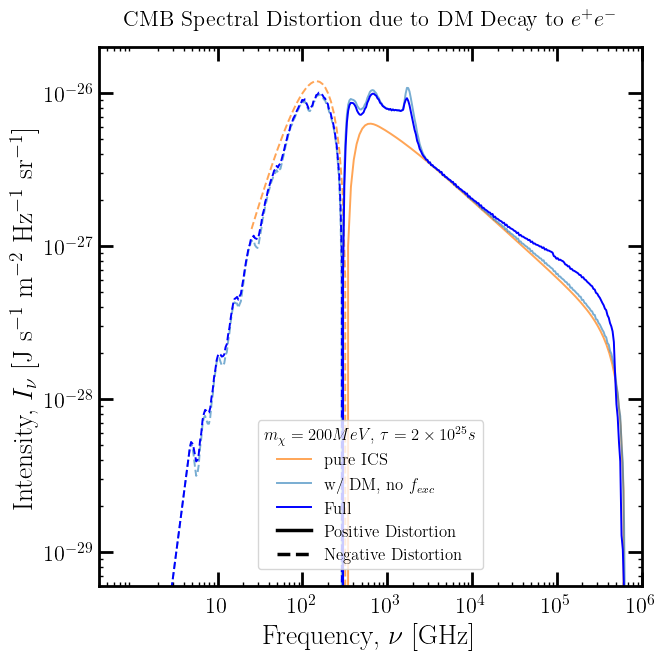

In [328]:
eng = baseline['distortion'].eng

hplanck = phys.hbar * 2*np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck
# rs_fac = 1300


plt.figure(figsize=(7, 7))
plt.loglog()
# plt.xscale('log')
plt.xlim([4e-1, 1e6])
plt.ylim([6e-30, 2e-26])

# DH generated data
plt.plot(tmp.eng/hplanck/1e9, phys.nB * tmp.eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4 * tmp.dNdE,
         color='C1', linewidth=1.4, label='pure ICS', alpha=0.7)
plt.plot(tmp.eng/hplanck/1e9, -phys.nB * tmp.eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4 * tmp.dNdE,
         color='C1', linestyle='--', linewidth=1.4, alpha=0.7)

plt.plot(nu/1e9, convert * DMrun['distortion'].dNdE,
         color='C0', linewidth=1.4,
         label='w/ DM, no $f_{exc}$', linestyle='solid', alpha=0.6)
plt.plot(nu/1e9, -convert * DMrun['distortion'].dNdE,
         color='C0', linewidth=1.4,
         linestyle='--', alpha=0.6)

plt.plot(nu/1e9, convert * DMrun_withf['distortion'].dNdE,
         color='blue', linestyle='solid', linewidth=1.4, label='Full')
plt.plot(nu/1e9, -convert * DMrun_withf['distortion'].dNdE,
         color='blue', linestyle='--', linewidth=1.4)

plt.plot(nu/1e9, np.ones_like(nu), color='k', 
         linestyle='solid', label='Positive Distortion')
plt.plot(nu/1e9, np.ones_like(nu), color='k', 
         linestyle='--', label='Negative Distortion')

plt.xticks([1e1,1e2,1e3,1e4,1e5,1e6])

leg = plt.legend(fontsize=12)
leg.set_title(r'$m_\chi = 200 MeV$, $\tau = 2 \times 10^{25}s$')
plt.setp(leg.get_title(),fontsize='12')


plt.xlabel(r'Frequency, $\nu$ [GHz]', fontsize=20)
plt.ylabel(r'Intensity, $I_{\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)
plt.title('CMB Spectral Distortion due to DM Decay to $e^+e^-$', fontsize=16)

# 3. $f_{exc}$ as an ionization source

In [219]:
rs_vec = DM_run0['rs']

Tr_vec, Tm_vec  = phys.TCMB(rs_vec), phys.Tm_std(rs_vec)
# Tm_vec = Tr_vec.copy()

xe_vec, x1s_vec  = phys.xHII_std(rs_vec), phys.xHI_std(rs_vec)
nH_vec = phys.nH * rs_vec**3

tau_vec = atomic.tau_np_1s(2,rs_vec)
x2s_vec = atomic.x2s_steady_state(rs_vec, Tr_vec, Tm_vec, xe_vec, x1s_vec, tau_vec)
x2_vec  = 4*x2s_vec

Text(0, 0.5, 'Fractional Difference in Ionization Rate')

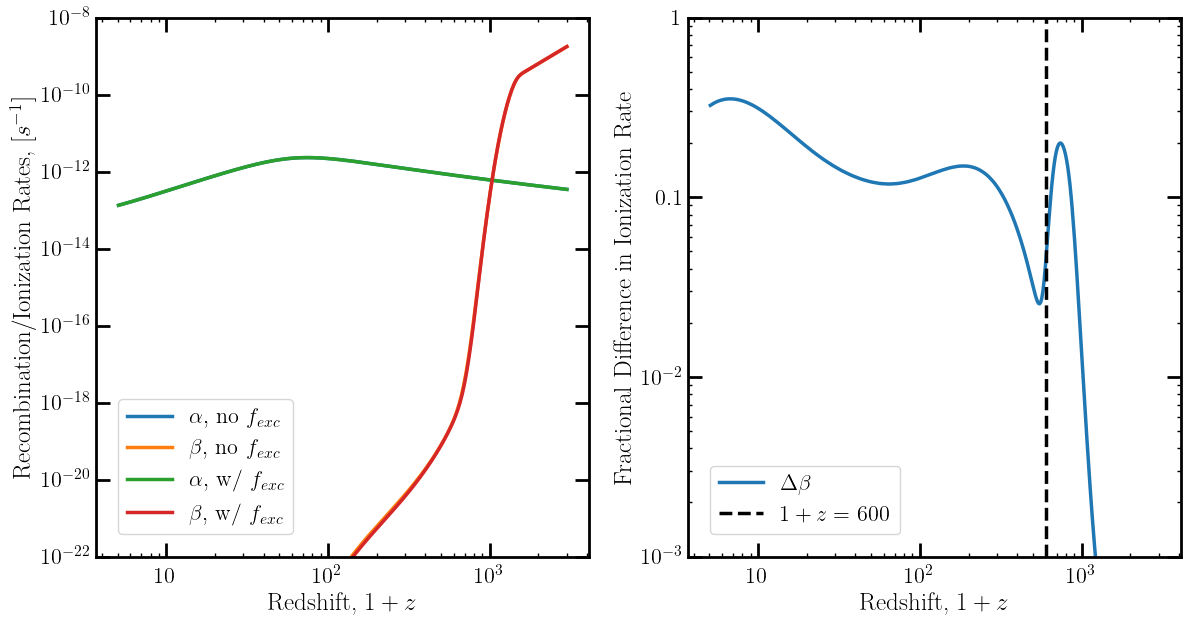

In [18]:
fig, axarr = plt.subplots(1,2, figsize=(14, 7))
axarr[0].loglog()
axarr[0].set_ylim([1e-22, 1e-8])

axarr[0].plot(DMrun_withf['rs'], DMrun_withf['MLA'][0][1:], label=r'$\alpha$, no $f_{exc}$')
axarr[0].plot(DMrun_withf['rs'], DMrun_withf['MLA'][1][1:], label=r'$\beta$, no $f_{exc}$')

axarr[0].plot(DMrun['rs'], DMrun['MLA'][0][1:], label=r'$\alpha$, w/ $f_{exc}$')
axarr[0].plot(DMrun['rs'], DMrun['MLA'][1][1:], label=r'$\beta$, w/ $f_{exc}$')

# axarr[0].plot(DM_run0['rs'], phys.alpha_recomb(Tm_vec, 'HI') + 0*xe_vec**2*nH_vec)
# rate = phys.beta_ion(Tr_vec, 'HI') * x2_vec
# axarr[0].plot(DM_run0['rs'], rate)

axarr[0].set_xlabel('Redshift, $1+z$')
axarr[0].set_ylabel('Recombination/Ionization Rates, [$s^{-1}$]')
axarr[0].legend()

# plt.plot(DM_run_withf0['rs'], np.abs(DM_run_withf0['MLA'][0][1:]/DM_run0['MLA'][0][1:]-1),
#          label=r'$\alpha$')


axarr[1].loglog()
axarr[1].set_ylim([1e-3, 1])
axarr[1].plot(DMrun_withf['rs'], DMrun_withf['MLA'][1][1:]/DMrun['MLA'][1][1:]-1,
         label=r'$\Delta \beta$')

axarr[1].axvline(600, linestyle='--', color='k', label=r'$1+z=600$')

axarr[1].legend()
axarr[1].set_xlabel('Redshift, $1+z$')
axarr[1].set_ylabel('Fractional Difference in Ionization Rate')

Text(0, 0.5, 'Fractional Difference in Ionization Rate')

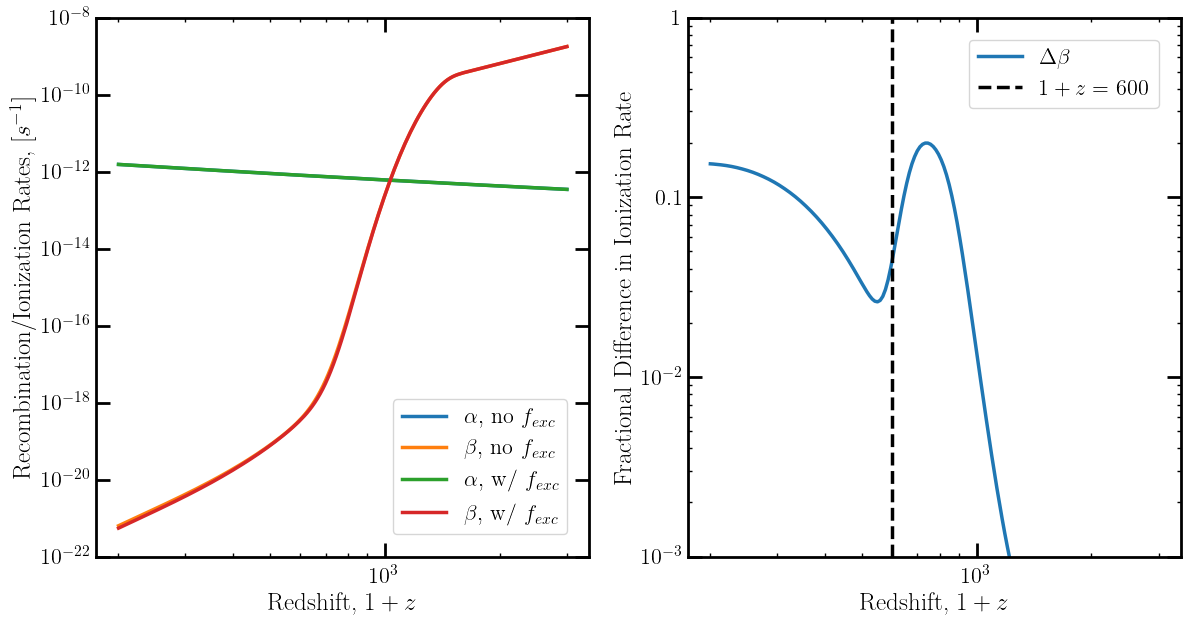

In [225]:
fig, axarr = plt.subplots(1,2, figsize=(14, 7))
axarr[0].loglog()
axarr[0].set_ylim([1e-22, 1e-8])

axarr[0].plot(DM_run_withf0['rs'], DMrun_withf['MLA'][0][1:], label=r'$\alpha$, no $f_{exc}$')
axarr[0].plot(DM_run_withf0['rs'], DMrun_withf['MLA'][1][1:], label=r'$\beta$, no $f_{exc}$')

axarr[0].plot(DM_run0['rs'], DMrun['MLA'][0][1:], label=r'$\alpha$, w/ $f_{exc}$')
axarr[0].plot(DM_run0['rs'], DMrun['MLA'][1][1:], label=r'$\beta$, w/ $f_{exc}$')

# axarr[0].plot(DM_run0['rs'], phys.alpha_recomb(Tm_vec, 'HI') + 0*xe_vec**2*nH_vec)
# rate = phys.beta_ion(Tr_vec, 'HI') * x2_vec
# axarr[0].plot(DM_run0['rs'], rate)

axarr[0].set_xlabel('Redshift, $1+z$')
axarr[0].set_ylabel('Recombination/Ionization Rates, [$s^{-1}$]')
axarr[0].legend()

# plt.plot(DM_run_withf0['rs'], np.abs(DM_run_withf0['MLA'][0][1:]/DM_run0['MLA'][0][1:]-1),
#          label=r'$\alpha$')


axarr[1].loglog()
axarr[1].set_ylim([1e-3, 1])
axarr[1].plot(DMrun_withf['rs'], DMrun_withf['MLA'][1][1:]/DMrun['MLA'][1][1:]-1,
         label=r'$\Delta \beta$')

axarr[1].axvline(600, linestyle='--', color='k', label=r'$1+z=600$')

axarr[1].legend()
axarr[1].set_xlabel('Redshift, $1+z$')
axarr[1].set_ylabel('Fractional Difference in Ionization Rate')

In [235]:
# import pickle
# MLA_data = pickle.load(open(
#     '/Users/gregoryridgway/Desktop/Data/'+
#     'MLA_rates_nmax100_nlogdlnz3.0_endrs200fudge1.125.dat', 'rb'
# ))

# MLA_funcs = np.array([
#     interp1d(DM_run_withf0['rs'], DM_run_withf0['MLA'][0][1:]),
#     interp1d(np.log(DM_run_withf0['rs']), np.log(DM_run_withf0['MLA'][1:]))
# ])

In [507]:
from darkhistory.history import tla

beta_func = interp1d(np.log(DMrun['rs']), np.log(DMrun['MLA'][1][1:]))
def beta_MLA(rs):
    return np.exp(beta_func(np.log(rs)))

MLA_funcs = np.array([
    interp1d(DMrun['rs'], DMrun['MLA'][0][1:]),
    beta_MLA
])

f_raw = {key: interp1d(DMrun['rs'], DMrun['f'][key],
                       bounds_error=False, fill_value = (0,0))
         for key in DMrun['f'].keys()}

def f_H_ion(rs, xHI, xHeI, xHeII):
    return f_raw['H ion'](rs)
def f_heat(rs, xHI, xHeI, xHeII):
    return f_raw['heat'](rs)
def f_H_exc(rs, xHI, xHeI, xHeII):
    return f_raw['Lya'](rs)

def rate_func_eng(rs):
    return phys.inj_rate(DM_process, rs, mDM=mDM, lifetime=param, sigmav=param)

rs_vec = 10**(np.arange(np.log10(3e3),np.log10(5.4),-.001*16))

iterated = tla.get_history(
    rs_vec, high_rs=np.inf,
    f_H_ion=f_H_ion, f_H_exc=f_H_exc, f_heating=f_heat,
    injection_rate=rate_func_eng,
    recfast_TLA=False,
    alpha_MLA=MLA_funcs[0], beta_MLA=MLA_funcs[1],
    mxstep=10000, rtol=1e-8
)

beta_func = interp1d(np.log(DMrun_withf['rs']), np.log(DMrun_withf['MLA'][1][1:]))
def beta_MLA(rs):
    return np.exp(beta_func(np.log(rs)))

MLA_funcs = np.array([
    interp1d(DMrun_withf['rs'], DMrun_withf['MLA'][0][1:]),
    beta_MLA
])

iterated_withf = tla.get_history(
    rs_vec, high_rs=np.inf,
    f_H_ion=f_H_ion, f_H_exc=f_H_exc, f_heating=f_heat,
    injection_rate=rate_func_eng,
    recfast_TLA=False,
    alpha_MLA=MLA_funcs[0], beta_MLA=MLA_funcs[1],
    mxstep=10000, rtol=1e-8
)

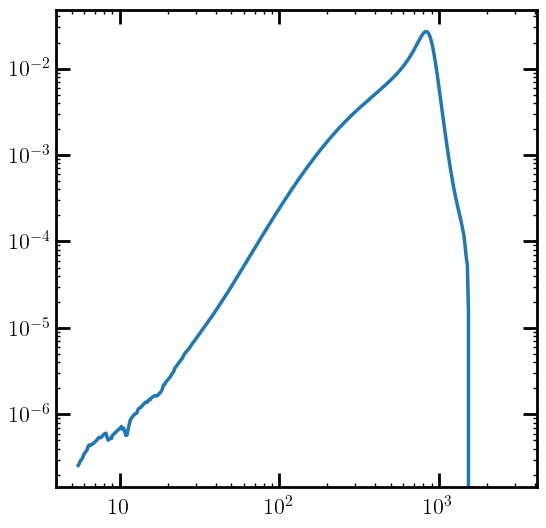

In [122]:
plt.figure()
plt.loglog()
# plt.plot(rs_vec, perturbed[:,1])
# plt.plot(rs_vec, perturbed0[:,1])

plt.plot(rs_vec, iterated_withf[:,1]/iterated[:,1]-1)
# plt.plot(rs_vec, iterated[:,1]/phys.xHII_std(rs_vec)-1)

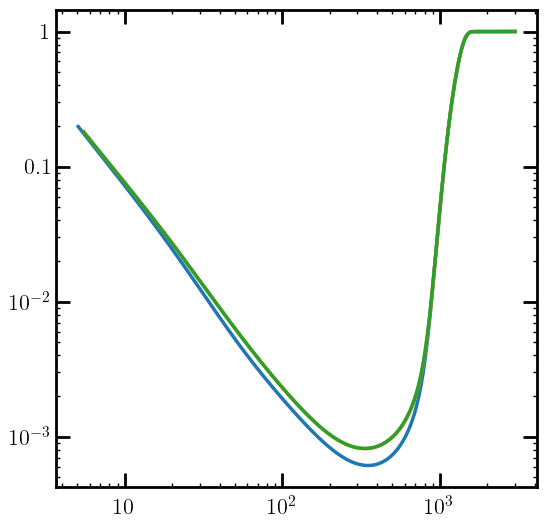

In [120]:
plt.figure()
plt.loglog()

plt.plot(DMrun['rs'], DMrun['x'][:,0])
# plt.plot(baseline['rs'], baseline['x'][:,0])
plt.plot(rs_vec, iterated[:,1])
plt.plot(rs_vec, iterated_withf[:,1])

# 4. $f_{ion}$ as a distortion source

In [198]:
%autoreload
DMrun_withf_nofion = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=lifetime,
    primary=pri+'_delta',
    start_rs = start_rs, high_rs = 1.555e3, end_rs=end_rs,
    coarsen_factor=coarsen_factor,
    distort=True, recfast_TLA=True,
    fexc_switch = True, reprocess_distortion=False, nmax=nmax
)

  0%|          | 0/400.0 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:442: RuntimeWarning: overflow encountered in true_divide
  K[nl, states_l == l+1] = BB['dn'][l+2:, n, l+1]/tot_rate
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:446: RuntimeWarning: overflow encountered in double_scalars
  K[0][1] = BB['dn'][2][1][0] / tot_rate
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:442: RuntimeWarning: divide by zero encountered in true_divide
  K[nl, states_l == l+1] = BB['dn'][l+2:, n, l+1]/tot_rate
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:446: RuntimeWarning: divide by zero encountered in double_scalars
  K[0][1] = BB['dn'][2][1][0] / tot_rate
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/D

Text(0, 0.5, 'Intensity, $I_{\\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]')

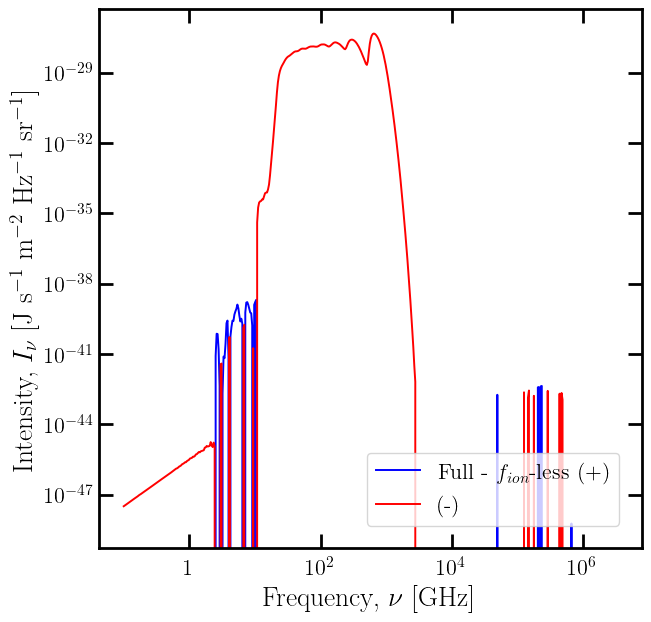

In [209]:
eng = baseline['distortion'].eng

hplanck = phys.hbar * 2*np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck
# rs_fac = 1300


plt.figure(figsize=(7, 7))
plt.loglog()
# plt.xlim([4e-1, 1e6])
# plt.ylim([6e-30, 2e-26])

# DH generated data
# plt.plot(nu/1e9, convert * baseline['distortion'].dNdE,
#          color='C0', linewidth=1.4, label='no DM')
# plt.plot(nu/1e9, convert * DM_run['distortion'].dNdE,
#          color='blue', linewidth=1.4,
#          label='w/ DM, no $f_{exc}$, (+)', linestyle='--', alpha=0.6)
# plt.plot(nu/1e9, -convert * DM_run['distortion'].dNdE,
#          color='red', linewidth=1.4,
#          label='(-)', linestyle='--', alpha=0.6)

# plt.plot(nu/1e9, convert * DM_run_withf['distortion'].dNdE,
#          color='blue', linewidth=1.4, label='w/ DM, w/ $f_{exc}$, (+)')
# plt.plot(nu/1e9, -convert * DM_run_withf['distortion'].dNdE,
#          color='red', linewidth=1.4)

plt.plot(nu/1e9, convert * (
    DM_run_withf['distortion'].dNdE - DM_run_withf_BF0['distortion'].dNdE),
         color='blue', linewidth=1.4, label='Full - $f_{ion}$-less (+)')
plt.plot(nu/1e9, -convert * (
    DM_run_withf['distortion'].dNdE - DM_run_withf_BF0['distortion'].dNdE),
         color='red', linewidth=1.4, label='(-)')

plt.legend(loc=4)

plt.xlabel(r'Frequency, $\nu$ [GHz]', fontsize=20)
plt.ylabel(r'Intensity, $I_{\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)

# 4. Distortion ($\Delta f_\gamma$) as an ionization source

In [123]:
%autoreload
DM_run_withf_withDf = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=lifetime,
    primary=pri+'_delta',
    start_rs = start_rs, high_rs = 1.555e3, end_rs=end_rs,
    coarsen_factor=coarsen_factor, backreaction=True,
    distort=True, recfast_TLA=True,
    fexc_switch = True, reprocess_distortion=True, nmax=nmax
)

  0%|          | 0/400.0 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)


In [137]:
MLA_funcs = np.array([
    interp1d(DM_run_withf_withDf['rs'], DM_run_withf_withDf['MLA'][0][1:]),
    interp1d(np.log(DM_run_withf_withDf['rs']), np.log(DM_run_withf_withDf['MLA'][1][1:]))
])

iterated_withf_withDf = tla.get_history(
    rs_vec, high_rs=np.inf,
    f_H_ion=f_H_ion, f_H_exc=f_H_exc, f_heating=f_heat,
    injection_rate=rate_func_eng,
    recfast_TLA=False,
    alpha_MLA=MLA_funcs[0], beta_MLA=MLA_funcs[1],
    mxstep=10000, rtol=1e-8
)

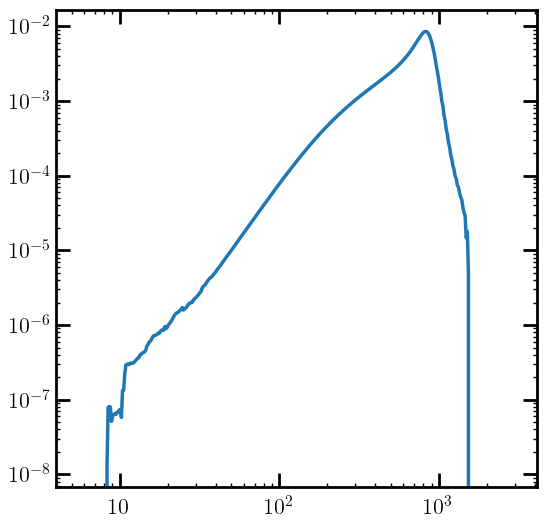

In [141]:
plt.figure()
plt.loglog()
# plt.plot(rs_vec, perturbed[:,1])
# plt.plot(rs_vec, perturbed0[:,1])

# plt.plot(rs_vec, iterated_withf[:,1]/iterated[:,1]-1)
plt.plot(rs_vec, iterated_withf_withDf[:,1]/iterated_withf[:,1]-1)
# plt.plot(rs_vec, iterated_withf_withDf[:,1]/iterated[:,1]-1)
# plt.plot(rs_vec, iterated[:,1]/phys.xHII_std(rs_vec)-1)

# 5. Reprocessing of distortion ($\Delta f_\gamma \to $ distortion)

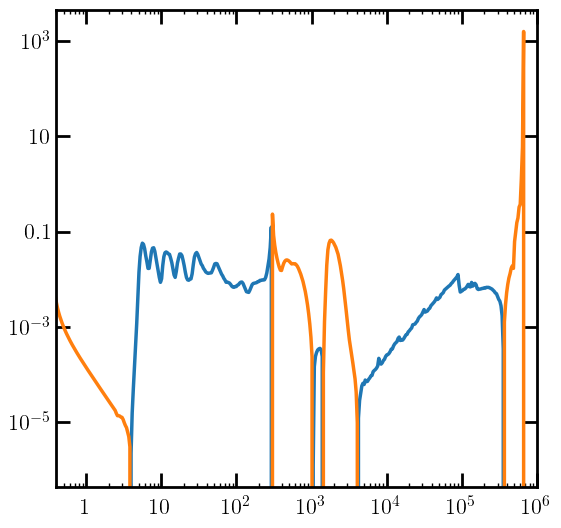

In [132]:
plt.figure()
plt.loglog()
# plt.xscale('log')
plt.xlim([4e-1, 1e6])
# plt.ylim([6e-30, 2e-26])

plt.plot(nu/1e9,
    (DM_run_withf_withDf['distortion'].dNdE+1e-200
    )/(DMrun_withf['distortion'].dNdE + 1e-200)-1
)
plt.plot(nu/1e9,
    1-(DM_run_withf_withDf['distortion'].dNdE+1e-200
    )/(DMrun_withf['distortion'].dNdE + 1e-200)
)

Text(0.5, 1.0, 'CMB Spectral Distortion due to DM Decay to $e^+e^-$')

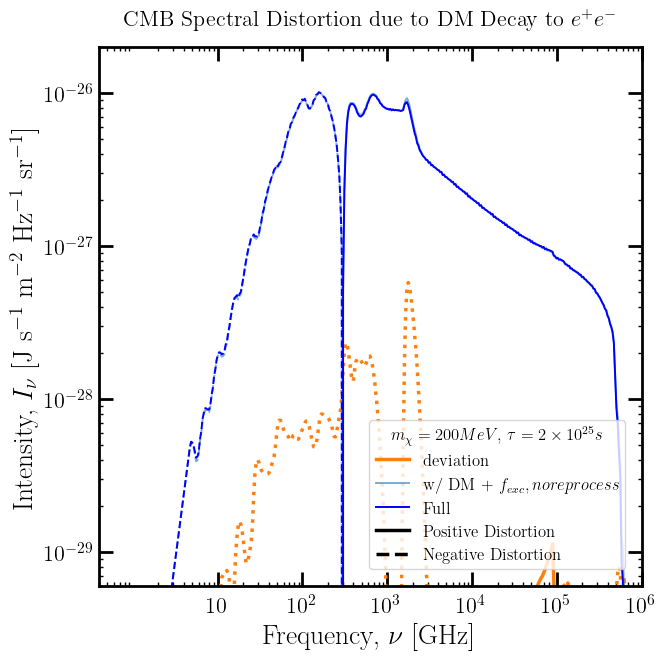

In [135]:
eng = baseline['distortion'].eng

hplanck = phys.hbar * 2*np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck
# rs_fac = 1300


plt.figure(figsize=(7, 7))
plt.loglog()
# plt.xscale('log')
plt.xlim([4e-1, 1e6])
plt.ylim([6e-30, 2e-26])

# DH generated data
# plt.plot(tmp.eng/hplanck/1e9, phys.nB * tmp.eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4 * tmp.dNdE,
#          color='C1', linewidth=1.4, label='pure ICS', alpha=0.7)
# plt.plot(tmp.eng/hplanck/1e9, -phys.nB * tmp.eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4 * tmp.dNdE,
#          color='C1', linestyle='--', linewidth=1.4, alpha=0.7)

plt.plot(nu/1e9,
         convert*(DM_run_withf_withDf['distortion'].dNdE-DMrun_withf['distortion'].dNdE),
         color='C1',
         label='deviation'
)
plt.plot(nu/1e9,
         -convert*(DM_run_withf_withDf['distortion'].dNdE-DMrun_withf['distortion'].dNdE),
         color='C1',
         linestyle=':'
)

plt.plot(nu/1e9, convert * DMrun_withf['distortion'].dNdE,
         color='C0', linewidth=1.4,
         label='w/ DM + $f_{exc}$, no reprocess', linestyle='solid', alpha=0.6)
plt.plot(nu/1e9, -convert * DMrun_withf['distortion'].dNdE,
         color='C0', linewidth=1.4,
         linestyle='--', alpha=0.6)

plt.plot(nu/1e9, convert * DM_run_withf_withDf['distortion'].dNdE,
         color='blue', linestyle='solid', linewidth=1.4, label='Full')
plt.plot(nu/1e9, -convert * DM_run_withf_withDf['distortion'].dNdE,
         color='blue', linestyle='--', linewidth=1.4)

plt.plot(nu/1e9, np.ones_like(nu), color='k', 
         linestyle='solid', label='Positive Distortion')
plt.plot(nu/1e9, np.ones_like(nu), color='k', 
         linestyle='--', label='Negative Distortion')

plt.xticks([1e1,1e2,1e3,1e4,1e5,1e6])

leg = plt.legend(fontsize=12)
leg.set_title(r'$m_\chi = 200 MeV$, $\tau = 2 \times 10^{25}s$')
plt.setp(leg.get_title(),fontsize='12')


plt.xlabel(r'Frequency, $\nu$ [GHz]', fontsize=20)
plt.ylabel(r'Intensity, $I_{\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)
plt.title('CMB Spectral Distortion due to DM Decay to $e^+e^-$', fontsize=16)

# Iteration

- Check that the iterative method is the same as reprocess_distortion=True at nmax=10.
- See that it fixes nmax=15
- See that at nmax=15 it converges quickly
- Do a scan, iterate twice, demonstrate convergence
- In main.evolve only use MLA_data, not alpha_MLA_data and beta_MLA_data (extra code)
- E>Rydberg photons in equilibrium a good approximation?
- Implement Wenzer's perturbative Tm and xe solutions at high rs.
- Try to fix reprocess by using a finer binning (if discrete redshift effects are to blame, think of other solutions, too)

- fixed_xe: Why doesn't the f_exc tail seem to converge like the rest does?
- iterated_xe: Why does the xe curve converge so slowly? Zoom into rs=800 and see what's happening there.

{- See that main.evolve and tla.get_history provide same x_e(z)}

In [ ]:
n_iter = 5

f_iterations = {}
f_iterations[0] = DMrun_withf

for i in np.arange(1,n_iter):
    
    iterations[i] = main.iterate(
        iterations[i-1],
        pri, DM_process, mDM, param,
        start_rs, end_rs, coarsen_factor,
        nmax, recfast_TLA=True
    )

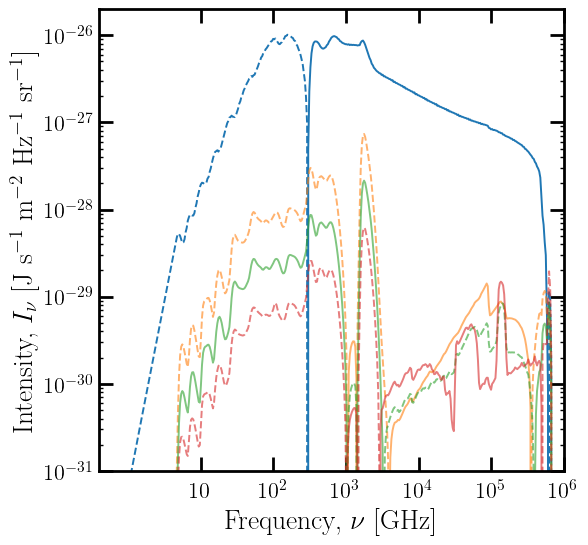

In [625]:
plt.figure(figsize=(6,6))
ax = plt.gca()

plot_distortion(ax, f_iterations[n_iter-1])
for i in np.arange(n_iter-1):
    plot_distortion(
        ax, f_iterations[i+1], f_iterations[i],
        diff=True, ylim=[1e-31, 2e-26], alpha=0.6
    )

In [785]:
rs_vec = DMrun_withf['rs']
MLA_data = DMrun_withf['MLA']
alpha_MLA = interp1d(rs_vec, MLA_data[0][1:],
                     bounds_error=False, fill_value='extrapolate')
beta_func = interp1d(np.log(rs_vec), np.log(MLA_data[1][1:]),
                     bounds_error=False, fill_value='extrapolate')
def beta_MLA(rs):
    return np.exp(beta_func(np.log(rs)))
MLA_funcs = [alpha_MLA, beta_MLA]

# to establish a baseline
DMrun_x_iter0 = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=param,
    sigmav=param,
    primary=pri+'_delta',
    start_rs = start_rs, high_rs = 1.555e3, end_rs=5,
    coarsen_factor=coarsen_factor,
    distort=True, recfast_TLA=False, MLA_funcs = MLA_funcs,
    fexc_switch = True, reprocess_distortion=False, nmax=nmax
)

  0%|          | 0/400.0 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:477: RuntimeWarning: overflow encountered in true_divide
  
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:481: RuntimeWarning: overflow encountered in double_scalars
  # Special 2s->1s transition
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:477: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:481: RuntimeWarning: divide by zero encountered in double_scalars
  # Special 2s->1s transition
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:508: RuntimeWarning: invalid value encountered in double_s

In [744]:
%autoreload

iterations[6] = main.iterate(
    iterations[5],
    pri, DM_process, mDM, param,
    start_rs, end_rs, coarsen_factor,
    nmax
)

  0%|          | 0/400 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)


  0%|          | 0/400.0 [00:00<?, ?it/s]

In [783]:
iterations_OLD = iterations.copy()

In [786]:
n_iter = 10

iterations = {}
iterations[0] = DMrun_x_iter0

for i in np.arange(1,n_iter):
    
    iterations[i] = main.iterate(
        iterations[i-1],
        pri, DM_process, mDM, param,
        start_rs, end_rs, coarsen_factor,
        nmax
    )

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../main.py:1395: RuntimeWarning: invalid value encountered in log
  beta_func = interp1d(np.log(rs_vec), np.log(MLA_data[1][1:]),


  0%|          | 0/400.0 [00:00<?, ?it/s]

42.536714247037445 [           nan            nan 5.43939893e-14 0.00000000e+00]


ValueError: Encountered nan in Tm or x

In [805]:
pri = 'elec'
rs_vec = DMrun_withf['rs']
MLA_data = DMrun_withf['MLA']
alpha_MLA = interp1d(rs_vec, MLA_data[0][1:],
                     bounds_error=False, fill_value='extrapolate')
beta_func = interp1d(np.log(rs_vec), np.log(MLA_data[1][1:]),
                     bounds_error=False, fill_value='extrapolate')
def beta_MLA(rs):
    return np.exp(beta_func(np.log(rs)))
MLA_funcs = [alpha_MLA, beta_MLA]

# to establish a baseline
DMrun_x_iter0 = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=param,
    sigmav=param,
    primary=pri+'_delta',
    start_rs = start_rs, high_rs = 1.555e3, end_rs=5,
    coarsen_factor=coarsen_factor,
    distort=True, recfast_TLA=False, MLA_funcs = MLA_funcs,
    fexc_switch = True, reprocess_distortion=True, nmax=nmax
)

  0%|          | 0/400.0 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)


In [807]:
%autoreload
n_iter = 10

repro = {}
repro[0] = DMrun_x_iter0

for i in np.arange(1,n_iter):
    
    repro[i] = main.iterate(
        repro[i-1],
        pri, DM_process, mDM, param,
        start_rs, end_rs, coarsen_factor,
        nmax
    )

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

In [692]:
%autoreload
rs_vec = DMrun_withf['rs']
MLA_data = DMrun_withf['MLA']
alpha_MLA = interp1d(rs_vec, MLA_data[0][1:],
                     bounds_error=False, fill_value='extrapolate')
beta_func = interp1d(np.log(rs_vec), np.log(MLA_data[1][1:]),
                     bounds_error=False, fill_value='extrapolate')
def beta_MLA(rs):
    return np.exp(beta_func(np.log(rs)))
MLA_funcs = [alpha_MLA, beta_MLA]

DMrun_full = main.evolve(  #
    DM_process=DM_process, mDM=mDM,
    lifetime=param,
    sigmav=param,
    primary=pri+'_delta',
    start_rs = start_rs, high_rs = 1.555e3, end_rs=end_rs,
    coarsen_factor=cf,
    distort=True, recfast_TLA=False,
    fexc_switch = True, reprocess_distortion=True, nmax=nmax
#     Delta_f_2D = Delta_f_2D_iter2  #
)

  0%|          | 0/6397.0 [00:00<?, ?it/s]

[0. 0. 0.]


/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)


[7.36456281e-18 7.26990750e-22 9.69683982e-19]
[ 1.45686246e-17 -7.68822102e-15  2.12998604e-18]
[ 1.90783482e-17 -1.36568744e-14  3.00618868e-18]
[ 1.81467892e-17 -1.90409317e-14  3.10590673e-18]
[ 2.19516846e-17 -2.39987116e-14  3.62156895e-18]
[ 2.66934136e-17 -2.86199552e-14  4.30359113e-18]
[ 2.29427899e-17 -3.29597381e-14  3.92402532e-18]
[ 2.31489611e-17 -3.70548366e-14  3.80760903e-18]
[ 2.65831178e-17 -4.09316377e-14  4.12367038e-18]
[ 2.75805683e-17 -4.46102791e-14  4.22626765e-18]
[ 2.87656326e-17 -4.81069116e-14  4.31783240e-18]
[ 3.18405122e-17 -5.14349615e-14  4.63535742e-18]
[ 3.75954838e-17 -5.46059715e-14  5.33262308e-18]
[ 3.44104459e-17 -5.76301405e-14  4.98897860e-18]
[ 3.38684061e-17 -6.05166089e-14  4.75345194e-18]
[ 3.16418647e-17 -6.32737087e-14  4.28636460e-18]
[ 2.70901978e-17 -6.59091290e-14  3.44756501e-18]
[ 2.75875845e-17 -6.84299388e-14  3.09209937e-18]
[ 2.89711351e-17 -7.08427018e-14  2.98593189e-18]
[ 2.82519328e-17 -7.31535799e-14  2.73841624e-18]
[ 2

KeyboardInterrupt: 

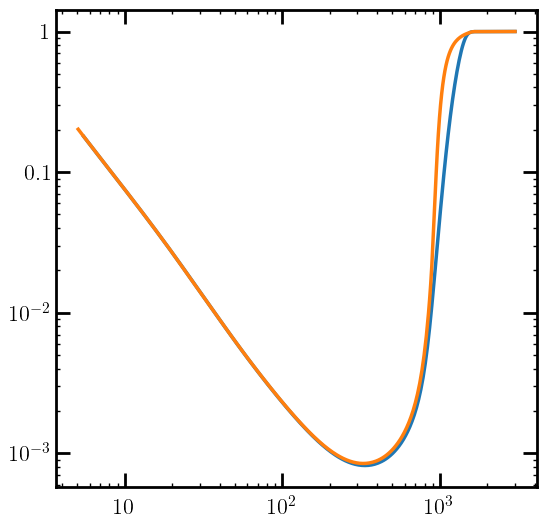

In [691]:
plt.figure()
plt.loglog()

plt.plot(iterations[0]['rs'], iterations[0]['x'][:,0])
plt.plot(DMrun_full['rs'], DMrun_full['x'][:,0])

In [1066]:
def plot_distortion(
    ax, run, run2=None,
    xlim=[4e-1, 1e6], ylim=[6e-30, 2e-26],
    label=None, color=None, title=None, alpha=1.0, leg=False,
    first=True, diff=False
):
    
    eng = run['distortion'].eng
    hplanck = phys.hbar * 2*np.pi
    nu = eng/hplanck
    convert = phys.nB * eng * hplanck * phys.c / (4*np.pi) * phys.ele * 1e4
    
    ax.loglog()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    if first:
        ax.plot(nu/1e9, np.ones_like(nu), color='k', 
            linestyle='solid', label='Positive Distortion')
        ax.plot(nu/1e9, np.ones_like(nu), color='k', 
            linestyle='--', label='Negative Distortion')
    
    if not diff:
        ax.plot(nu/1e9, convert * run['distortion'].dNdE,
            color=color, linewidth=1.4,
            label=label, linestyle='solid', alpha=alpha)

        ax.plot(nu/1e9, -convert * run['distortion'].dNdE,
            color=ax.get_lines()[-1].get_color(), linewidth=1.4,
            linestyle='--', alpha=alpha)
        
    else:
        ax.plot(nu/1e9, convert * (run['distortion'].dNdE - run2['distortion'].dNdE),
            color=color, linewidth=1.4,
            label=label, linestyle='solid', alpha=alpha)

        ax.plot(nu/1e9, -convert * (run['distortion'].dNdE - run2['distortion'].dNdE),
            color=ax.get_lines()[-1].get_color(), linewidth=1.4,
            linestyle='--', alpha=alpha)
    
#     ax.set_xticks([1e1,1e2,1e3,1e4,1e5,1e6])
    
    ax.set_xlabel(r'Frequency, $\nu$ [GHz]', fontsize=20)
    ax.set_ylabel(r'Intensity, $I_{\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)
    ax.set_title(title, fontsize=16)
    
    if leg:
        ax.legend()
        # leg = axarr[0].legend(fontsize=12, loc=1)
        # leg.set_title(r'$m_\chi = 200 MeV$, $\tau = 2 \times 10^{25}s$')
        # axarr[0].setp(leg.get_title(),fontsize='12')

(200, 2000.0)

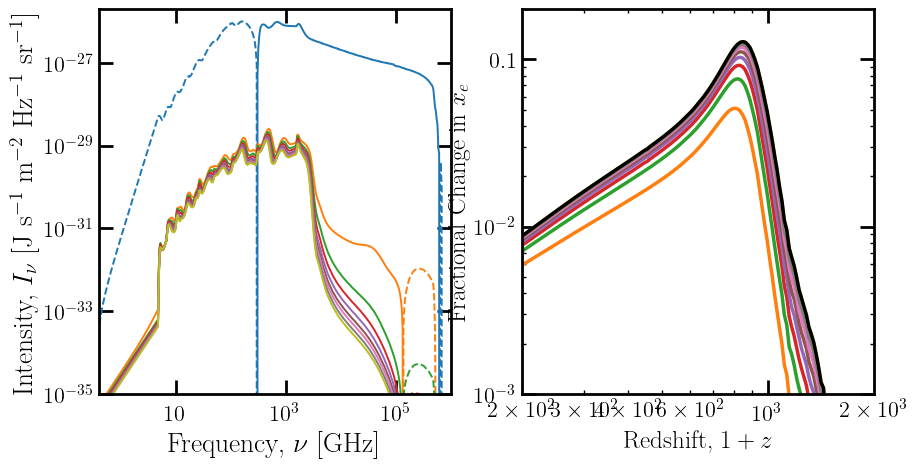

In [1152]:
f, axarr = plt.subplots(1,2, figsize=(10, 5))
n_iter=9

plot_distortion(axarr[0], repro[0])
for i in np.arange(n_iter-1):
    plot_distortion(
        axarr[0], repro[i+1], repro[i], diff=True, ylim=[1e-35, 2e-26]
    )
    

axarr[1].loglog()
for i in np.arange(n_iter-1):
    axarr[1].plot(repro[i+1]['rs'][:], 
                  np.abs(repro[i+1]['x'][:,0]/repro[0]['x'][:,0]-1),
                  color='C'+str(i+1))
    
axarr[1].plot(repro[n_iter-1]['rs'][:], 
                  np.abs(repro[n_iter-1]['x'][:,0]/repro[0]['x'][:,0]-1),
              color='k')

axarr[1].set_xlabel('Redshift, $1+z$')
axarr[1].set_ylabel('Fractional Change in $x_e$')
axarr[1].set_ylim([1e-3,.2])
axarr[1].set_xlim([200,2e3])

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)


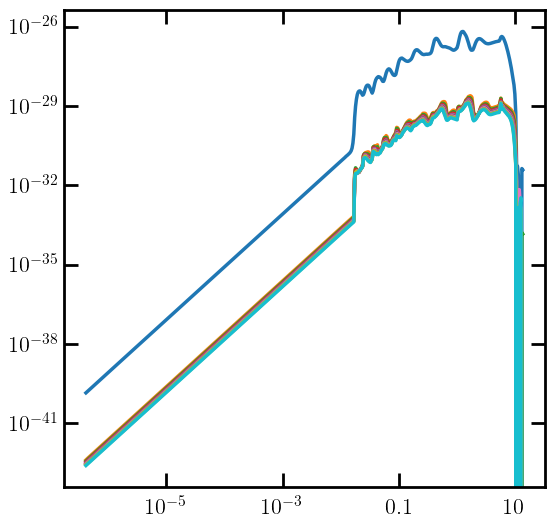

In [1155]:
plt.figure()
plt.loglog()

run = repro[0]

rs_list = run['rs']
rs_eval = 850

eng = run['distortion'].eng
hplanck = phys.hbar * 2*np.pi
nu = eng/hplanck
convert = phys.nB * eng * hplanck * phys.c / (4*np.pi) * phys.ele * 1e4
    
run = repro[0]

specs = {}
for i,r in enumerate(repro):
    dists = repro[i]['distortions'].copy()
    dists.redshift(rs_eval)
    specs[i] = dists.sum_specs(rs_list > rs_eval)
    
    
plt.plot(eng, convert * (specs[0].dNdE))
for i in np.arange(len(repro)-1):
#     plt.plot(eng, convert * (specs[i].dNdE))
    plt.plot(eng, convert * (specs[i+1].dNdE-specs[i].dNdE))
#     plt.plot(eng, specs[i+1].dNdE/specs[i].dNdE - 1)

# plt.plot(eng, convert * (spec1.dNdE-spec0.dNdE))
# plt.plot(eng, -convert * (spec1.dNdE-spec0.dNdE), color='C'+str(i), linestyle='--')

In [1434]:
%autoreload

pri = 'elec'
DM_process = 'decay'
mDM = 2e8
# mDM = 10**log10eng[::10][1] + phys.me
# mDM = 10**6.5
nmax=10

param = param_bound(mDM, DM_process, pri)
coarsen_factor = 16
string = str(int(np.floor(np.log10(mDM))))
start_rs = 3e3
end_rs = 5

# x_debug_fixed_x = {}  # set x = x_std, Delta_f=0, Tm=TCMB for rate calculations
# x_debug = {}  # don't, but also don't absorb line photons
x_dict = x_debug_fixed_x

x_dict[-1] = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=param*1e20,
    sigmav=param,
    primary=pri+'_delta',
    start_rs = 2e3, high_rs = 1.555e3, end_rs=700,
    coarsen_factor=coarsen_factor,
    distort=True, recfast_TLA=True, reprocess_distortion=True,
    fexc_switch = False, nmax=nmax
)

  0%|          | 0/66.0 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)


In [1435]:
run = x_dict[-1]  # DMrun_withf

rs_vec = run['rs']
MLA_data = run['MLA']
alpha_MLA = interp1d(rs_vec, MLA_data[0][1:],
                     bounds_error=False, fill_value='extrapolate')
beta_func = interp1d(np.log(rs_vec), np.log(MLA_data[1][1:]),
                     bounds_error=False, fill_value='extrapolate')
def beta_MLA(rs):
    return np.exp(beta_func(np.log(rs)))
MLA_funcs = [alpha_MLA, beta_MLA]

x_dict[0] = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=param*1e20,
    sigmav=param,
    primary=pri+'_delta',
    start_rs = 2e3, high_rs = 1.555e3, end_rs=700,
    coarsen_factor=coarsen_factor,
    distort=True, recfast_TLA=False, MLA_funcs = MLA_funcs,
    fexc_switch = False, reprocess_distortion=True, nmax=nmax, rtol=1e-6
)

  0%|          | 0/66.0 [00:00<?, ?it/s]

In [1436]:
%autoreload

for i in np.arange(1,4):
    x_dict[i] = main.iterate(
        x_dict[i-1],
        pri, DM_process, mDM, param*1e20,
        2e3, 7e2, coarsen_factor,
        nmax, reprocess_distortion=True, fexc_switch=False,
        rtol=1e-6
    )

  0%|          | 0/66.0 [00:00<?, ?it/s]

  0%|          | 0/66.0 [00:00<?, ?it/s]

  0%|          | 0/66.0 [00:00<?, ?it/s]

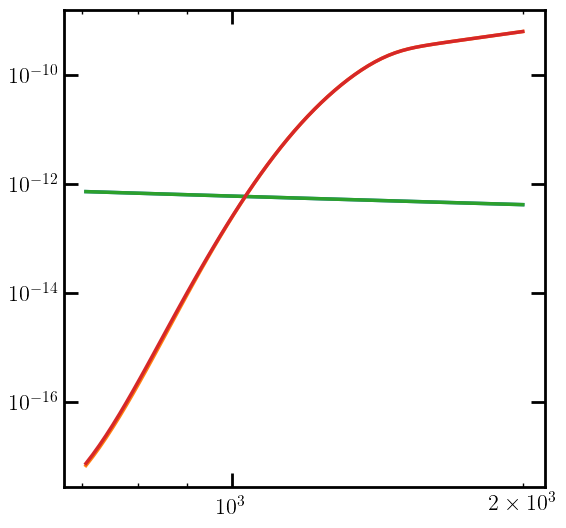

In [1441]:
plt.figure()
plt.loglog()

plt.plot(x_dict[0]['rs'], x_dict[0]['MLA'][0][1:])
plt.plot(x_dict[0]['rs'], x_dict[0]['MLA'][1][1:])

plt.plot(x_dict[3]['rs'], x_dict[3]['MLA'][0][1:])
plt.plot(x_dict[3]['rs'], x_dict[3]['MLA'][1][1:])

Text(0.5, 0, 'Redshift, $1+z$')

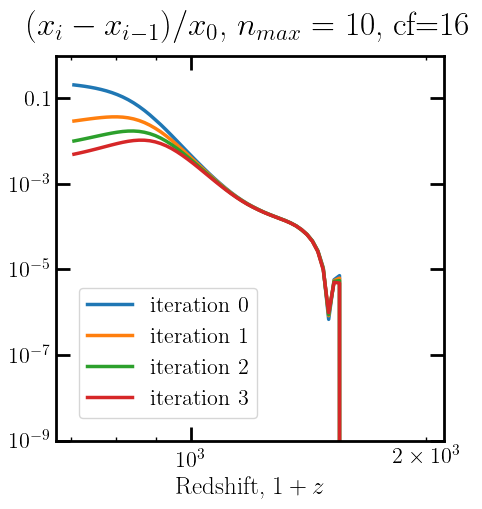

In [1437]:
plt.figure(figsize=(5,5))
plt.loglog()
plt.ylim([1e-9,1])

for i in np.arange(0,4):
    plt.plot(x_dict[i-1]['rs'], 
             np.abs((x_dict[i]['x'][:,0]-x_dict[i-1]['x'][:,0]))/x_dict[0]['x'][:,0],
             label='iteration '+str(i))
    
plt.legend()
plt.title('$(x_i - x_{i-1})/x_0$, $n_{max}=10$, cf=16')
plt.xlabel('Redshift, $1+z$')

#     plt.plot(x_dict[i-1]['rs'], np.abs(x_dict[i]['MLA'][1]/x_dict[i-1]['MLA'][1]-1)[1:],
#             linestyle='solid')
#     plt.plot(x_dict[i-1]['rs'], np.abs(x_dict[i]['MLA'][0]/x_dict[i-1]['MLA'][0]-1)[1:],
#             linestyle='--')

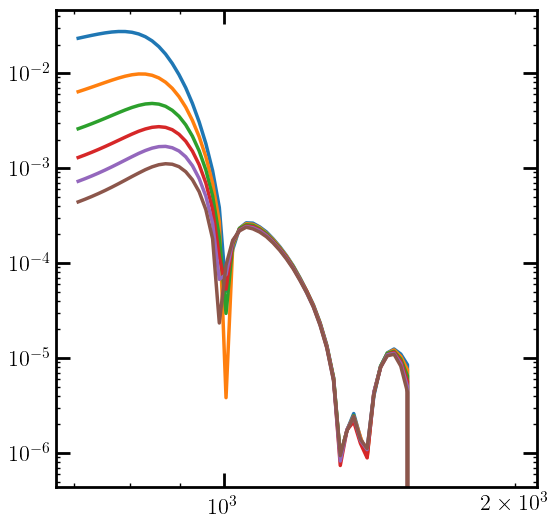

In [1331]:
plt.figure()
plt.loglog()

for i in np.arange(1,3):
    plt.plot(x_dict[i-1]['rs'], np.abs(x_dict[i]['x'][:,0]/x_dict[i-1]['x'][:,0]-1))
# plt.plot(x_debug[0]['rs'], np.abs(x_debug[1]['Tm']/x_debug[0]['Tm']-1))
# plt.plot(x_debug[0]['rs'], np.abs(np.abs(phys.Tm_std(x_debug[0]['rs'])/phys.TCMB(x_debug[0]['rs'])-1)))

## ???

In [243]:
%autoreload
DM_run_withf_withDf = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=lifetime,
    primary=pri+'_delta',
    start_rs = start_rs, high_rs = 1.555e3, end_rs=end_rs,
    coarsen_factor=coarsen_factor, backreaction=True,
    cross_check=False, distort=True, recfast_TLA=True,
    fexc_switch = True, reprocess_distortion=True, nmax=nmax
)

  0%|          | 0/400.0 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:466: RuntimeWarning: overflow encountered in true_divide
  b[nl] += xHI*BB['dn'][2][1][0]*np.exp(-phys.lya_eng/Tr)
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:470: RuntimeWarning: overflow encountered in double_scalars
  spec_ind = str(n) + num_to_l(l)
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/exam

In [295]:
rs_cut = 5

tmp = DM_run_withf_withDf2['distortions'].copy()
tmp.redshift(1.)

mask = np.ones_like(tmp.rs)
mask[DM_run_withf_withDf2['distortions'].rs < rs_cut] = 0

tmp = tmp.sum_specs(mask)

tmp2 = DM_run_withf['distortions'].copy()
tmp2.redshift(1.)

mask = np.ones_like(tmp2.rs)
mask[DM_run_withf['distortions'].rs < rs_cut] = 0

tmp2 = tmp2.sum_specs(mask)

Text(0, 0.5, 'Intensity, $I_{\\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]')

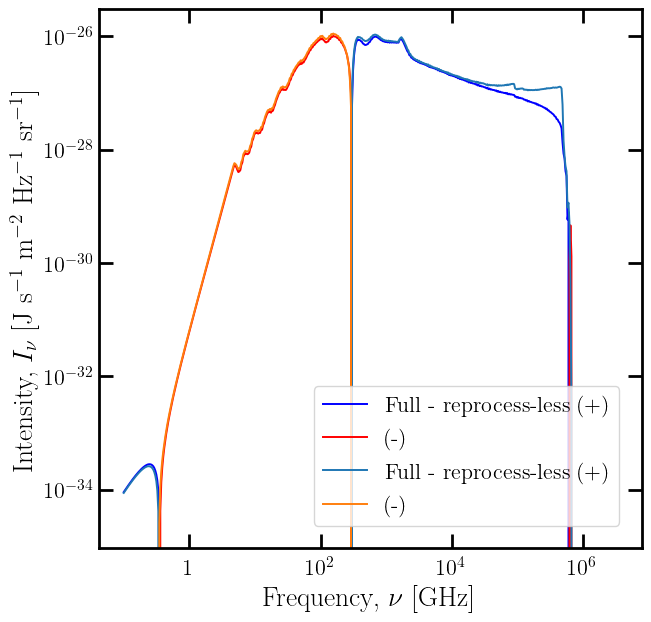

In [297]:
eng = baseline['distortion'].eng

plt.figure(figsize=(7, 7))
plt.loglog()

hplanck = phys.hbar * 2*np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck

# plt.plot(nu/1e9, convert * (
#     DM_run_withf_withDf2['distortion'].dNdE - DM_run_withf_withDf['distortion'].dNdE),
#          color='blue', linewidth=1.4, label='Full - reprocess-less (+)')
# plt.plot(nu/1e9, -convert * (
#     DM_run_withf_withDf2['distortion'].dNdE - DM_run_withf_withDf['distortion'].dNdE),
#          color='red', linewidth=1.4, label='(-)')

plt.plot(nu/1e9, convert * tmp.dNdE,
         color='blue', linewidth=1.4, label='Full - reprocess-less (+)')
plt.plot(nu/1e9, -convert * tmp.dNdE,
         color='red', linewidth=1.4, label='(-)')

plt.plot(nu/1e9, convert * tmp2.dNdE,
         color='C0', linewidth=1.4, label='Full - reprocess-less (+)')
plt.plot(nu/1e9, -convert * tmp2.dNdE,
         color='C1', linewidth=1.4, label='(-)')

plt.legend(loc=4)

plt.xlabel(r'Frequency, $\nu$ [GHz]', fontsize=20)
plt.ylabel(r'Intensity, $I_{\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)

# Scans

In [180]:
log10eng0 = 3.6989700794219966
log10eng = np.array([log10eng0 + 0.23252559*i for i in np.arange(40)])
log10eng[-1] = 12.601505994846297

models = ['elec_decay', 'elec_swave', 'phot_decay', 'phot_swave']
data = {model : [] for model in models}

for pri in ['elec', 'phot']:
    for DM_process in ['decay', 'swave']:
        
        model = pri+'_'+DM_process
        print('starting', model)
        
        if pri=='elec':
            if DM_process=='decay':
                mDM_list = 2*(10**log10eng + phys.me)
            else:
                mDM_list = 10**log10eng + phys.me

        elif pri=='phot':
            if DM_process=='decay':
                mDM_list = 2*10**log10eng
            else:
                mDM_list = 10**log10eng
        
        for mDM in tqdm(mDM_list[::10]):
            
            param = param_bound(mDM, DM_process, pri)

            goods = main.evolve(
                DM_process=DM_process, mDM=mDM,
                lifetime=param,
                sigmav = param,
                primary=pri+'_delta',
                start_rs = start_rs, high_rs = 1.555e3, end_rs=end_rs,
                coarsen_factor=coarsen_factor, backreaction=True,
                distort=True, recfast_TLA=True,
                fexc_switch = True, reprocess_distortion=True, nmax=nmax
            )
            
            data[model].append(goods)
            
# pickle.dump(data, open('/Users/gregoryridgway/Desktop/Data/'+
#                        'scan_nmax10_every10th.dat','wb'))

starting elec_decay


/var/folders/kq/gkzlnb6576x8mxsf32v72_y00000gn/T/ipykernel_71122/250757274.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for mDM in tqdm(mDM_list[::10]):


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/76.0 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../main.py:737: RuntimeWarning: invalid value encountered in log
  np.log(beta_MLA_data[:, 1]),


  0%|          | 0/76.0 [00:00<?, ?it/s]

KeyboardInterrupt: 

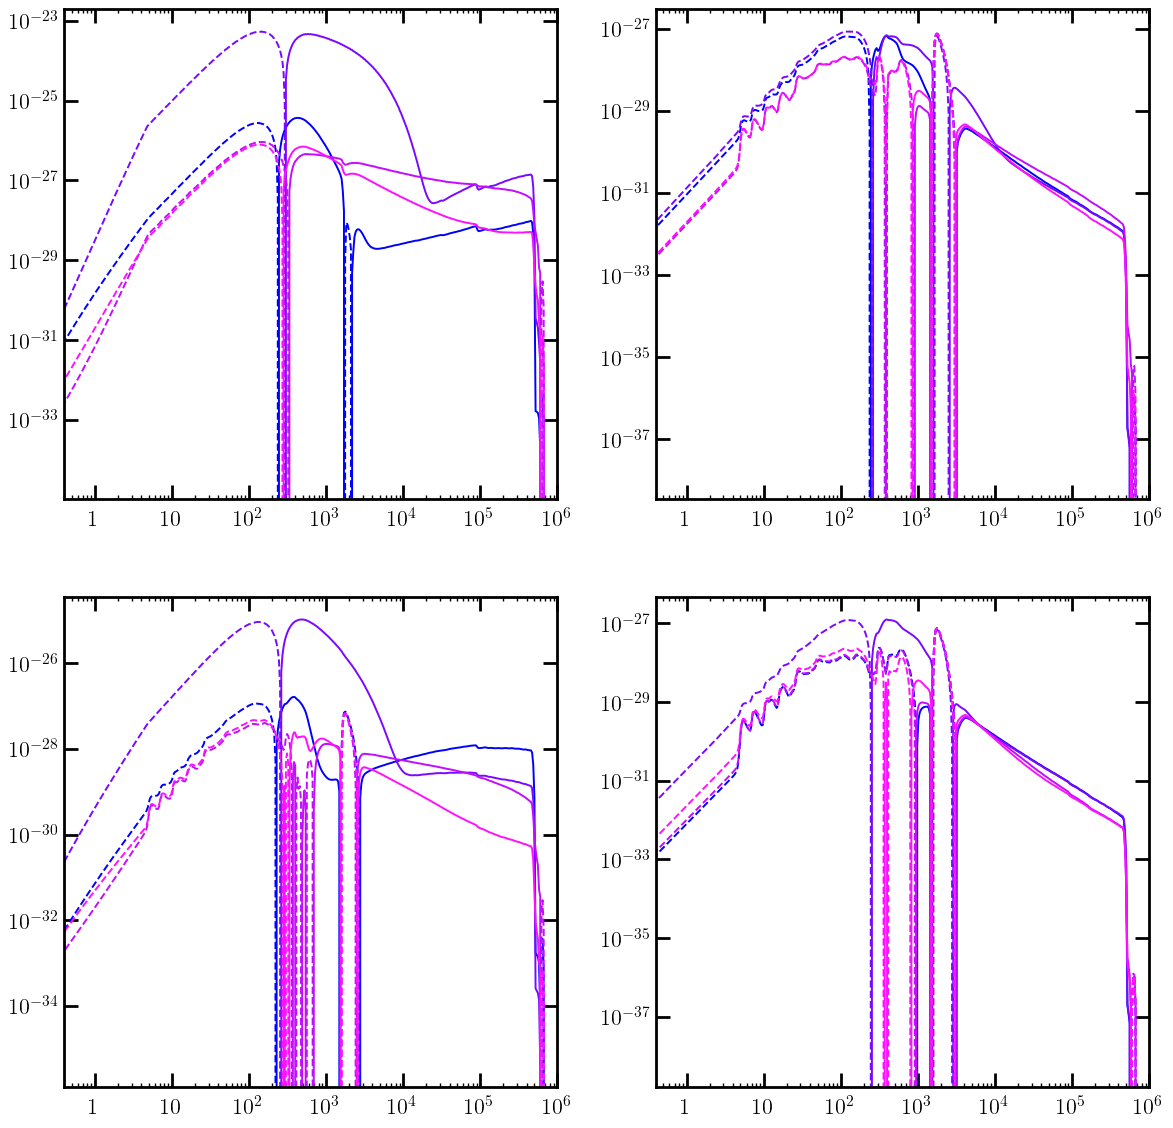

In [185]:
datums = pickle.load(open('/Users/gregoryridgway/Desktop/Data/'+
                       'scan_nmax10_every10th.dat','rb'))

fig, axarr = plt.subplots(2,2, figsize=(14, 14))

cs = np.linspace(0,1,len(datums['elec_decay']))**0.66

for i, pri in enumerate(['elec', 'phot']):
    for j, DM_process in enumerate(['decay', 'swave']):
        axarr[i][j].loglog()
        # plt.xscale('log')
        axarr[i][j].set_xlim([4e-1, 1e6])
#         if DM_process == 'swave':
#             axarr[i][j].set_ylim([6e-30, 2e-26])
#         else:
#             axarr[i][j].set_ylim([6e-30, 8e-24])
        
        model = pri+'_'+DM_process
        
        for k in np.arange(4):
            axarr[i][j].plot(nu/1e9, convert * datums[model][k]['distortion'].dNdE-convert * baseline['distortion'].dNdE,
                             color=(cs[k],cs[k]/15,1), linestyle='solid', linewidth=1.4)
            axarr[i][j].plot(nu/1e9, -convert * datums[model][k]['distortion'].dNdE+convert * baseline['distortion'].dNdE,
                             color=(cs[k],cs[k]/15,1), linestyle='--', linewidth=1.4)
            
#             axarr[i][j].plot(nu/1e9, convert * datums[model][k]['distortion'].dNdE,
#                              color=(cs[k],cs[k]/15,1), linestyle='solid', linewidth=1.4)
#             axarr[i][j].plot(nu/1e9, -convert * datums[model][k]['distortion'].dNdE,
#                              color=(cs[k],cs[k]/15,1), linestyle='--', linewidth=1.4)
            
#             axarr[i][j].plot(nu/1e9, convert * baseline['distortion'].dNdE,
#              color='k', linewidth=2.4, label='pure recombination (no DM)', alpha=1.0)

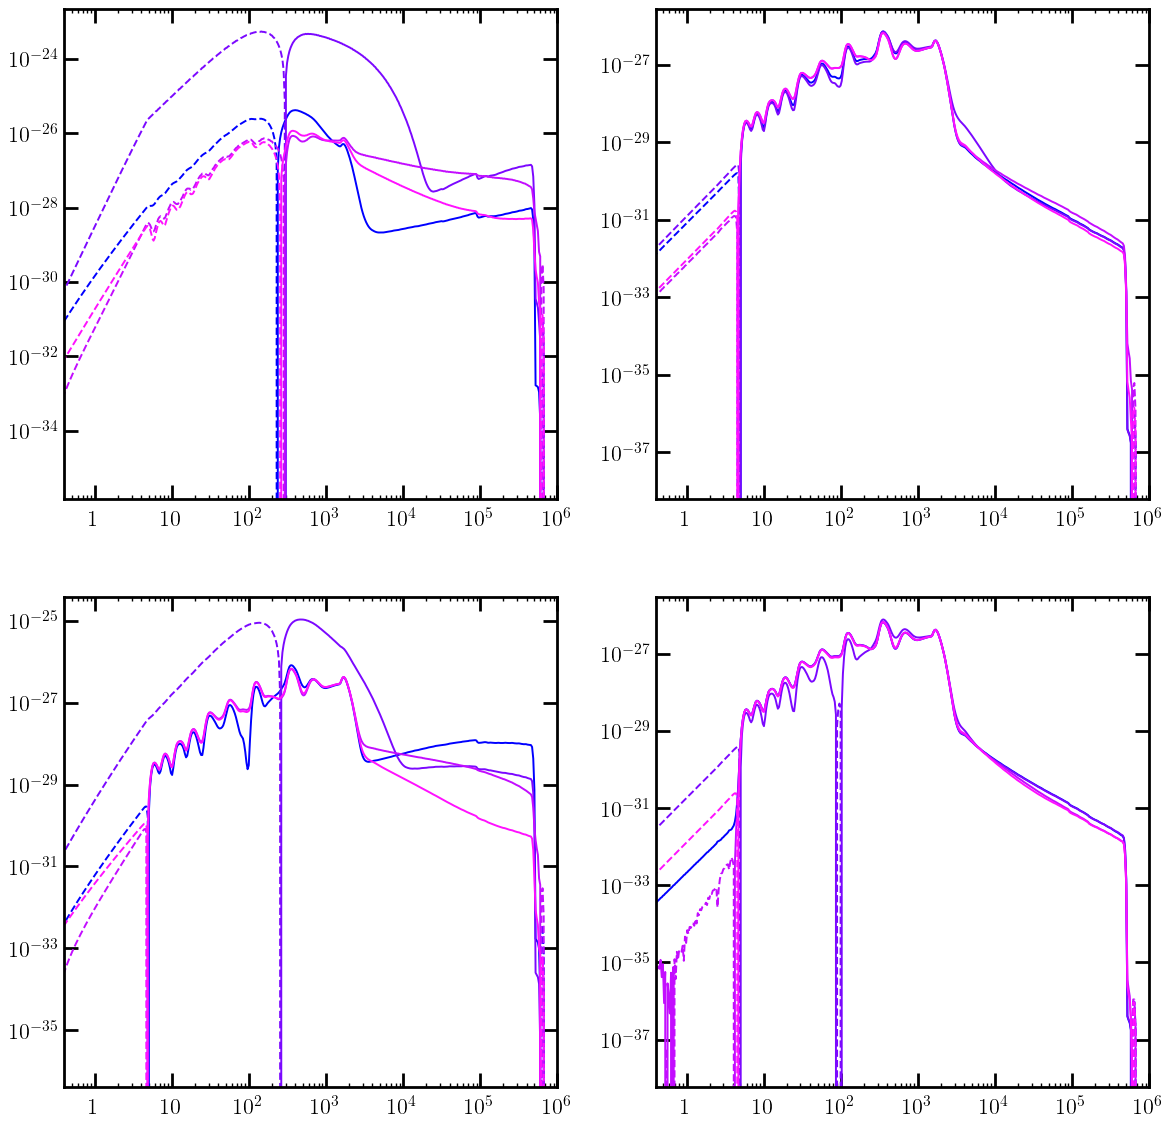

In [170]:
datums = pickle.load(open('/Users/gregoryridgway/Desktop/Data/'+
                       'scan_nmax10_every10th.dat','rb'))

eng = datums['elec_decay'][0]['distortion'].eng
hplanck = phys.hbar * 2*np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck

fig, axarr = plt.subplots(2,2, figsize=(14, 14))

cs = np.linspace(0,1,len(datums['elec_decay']))**0.66

for i, pri in enumerate(['elec', 'phot']):
    for j, DM_process in enumerate(['decay', 'swave']):
        axarr[i][j].loglog()
        # plt.xscale('log')
        axarr[i][j].set_xlim([4e-1, 1e6])
#         if DM_process == 'swave':
#             axarr[i][j].set_ylim([6e-30, 2e-26])
#         else:
#             axarr[i][j].set_ylim([6e-30, 8e-24])
        
        model = pri+'_'+DM_process
        
        for k in np.arange(4):
#             axarr[i][j].plot(nu/1e9, convert * datums[model][k]['distortion'].dNdE-convert * baseline['distortion'].dNdE,
#                              color=(cs[k],cs[k]/15,1), linestyle='solid', linewidth=1.4)
#             axarr[i][j].plot(nu/1e9, -convert * datums[model][k]['distortion'].dNdE+convert * baseline['distortion'].dNdE,
#                              color=(cs[k],cs[k]/15,1), linestyle='--', linewidth=1.4)
            
            axarr[i][j].plot(nu/1e9, convert * datums[model][k]['distortion'].dNdE,
                             color=(cs[k],cs[k]/15,1), linestyle='solid', linewidth=1.4)
            axarr[i][j].plot(nu/1e9, -convert * datums[model][k]['distortion'].dNdE,
                             color=(cs[k],cs[k]/15,1), linestyle='--', linewidth=1.4)
            
#             axarr[i][j].plot(nu/1e9, convert * baseline['distortion'].dNdE,
#              color='k', linewidth=2.4, label='pure recombination (no DM)', alpha=1.0)

In [146]:
log10eng0 = 3.6989700794219966
log10eng = np.array([log10eng0 + 0.23252559*i for i in np.arange(40)])
log10eng[-1] = 12.601505994846297

models = ['elec_decay', 'elec_swave', 'phot_decay', 'phot_swave']
data2 = {model : [] for model in models}

for pri in ['elec', 'phot']:
    for DM_process in ['decay', 'swave']:
        
        model = pri+'_'+DM_process
        print('starting', model)
        
        if pri=='elec':
            if DM_process=='decay':
                mDM_list = 2*(10**log10eng + phys.me)
            else:
                mDM_list = 10**log10eng + phys.me

        elif pri=='phot':
            if DM_process=='decay':
                mDM_list = 2*10**log10eng
            else:
                mDM_list = 10**log10eng
        
        for mDM in tqdm(mDM_list[5::10]):
            
            param = param_bound(mDM, DM_process, pri)

            goods = main.evolve(
                DM_process=DM_process, mDM=mDM,
                lifetime=param,
                sigmav = param,
                primary=pri+'_delta',
                start_rs = start_rs, high_rs = 1.555e3, end_rs=end_rs,
                coarsen_factor=coarsen_factor, backreaction=True,
                distort=True, recfast_TLA=True,
                fexc_switch = True, reprocess_distortion=True, nmax=nmax
            )
            
            data2[model].append(goods)
            
# pickle.dump(data2, open('/Users/gregoryridgway/Desktop/Data/'+
#                        'scan_nmax10_every10th_5.dat','wb'))

starting elec_decay


/var/folders/kq/gkzlnb6576x8mxsf32v72_y00000gn/T/ipykernel_58792/567884332.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for mDM in tqdm(mDM_list[5::10]):


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Scratch Work

In [136]:
%autoreload
DM_run_fcont = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=lifetime,
    primary=pri+'_delta',
    start_rs = start_rs, high_rs = 1.555e3, end_rs=end_rs,
    coarsen_factor=coarsen_factor, backreaction=False,
    cross_check=False, distort=False, recfast_TLA=True,
    fexc_switch=True, nmax=nmax
)

  0%|          | 0/400.0 [00:00<?, ?it/s]

0.008017952653325142
0.32658172814614705
0.6643936413646182
0.35060232080204035


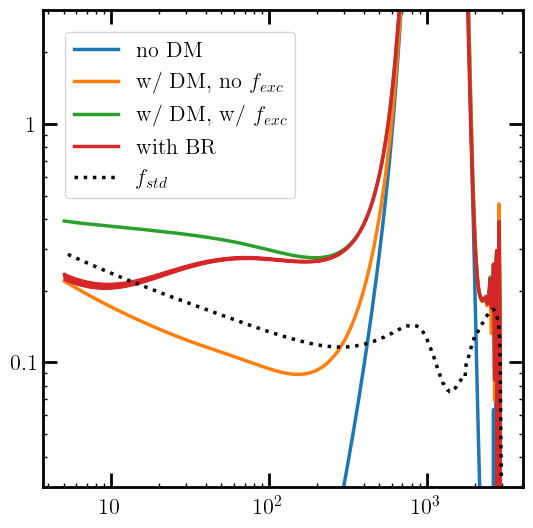

In [298]:
plt.figure()
plt.loglog()
plt.ylim([3e-2, 3])

norm_facs = (
    phys.nB * baseline['rs']**3 /
    (.001*coarsen_factor / phys.hubble(baseline['rs'])) / 
    phys.inj_rate('decay', baseline['rs'], mDM, lifetime=lifetime)
)

tmp_base = np.squeeze(
    baseline['distortions'].toteng('eng', np.array([1e-12,10.2]))
) * norm_facs

strings = ['no DM', 'w/ DM, no $f_{exc}$', 'w/ DM, w/ $f_{exc}$', 'with BR']
# for tmp in [DM_run, DM_run_withf]:
for lab, tmp in zip(strings,[baseline, DM_run, DM_run_withf, DM_run_withf2]):
    print(tmp['distortion'].toteng())
    f_cont_input = np.squeeze(
        tmp['distortions'].toteng('eng', np.array([1e-12,10.2]))
    ) * norm_facs
    
#     plt.plot(tmp['rs'][1:], f_cont_input[1:]-tmp_base[1:])
    plt.plot(tmp['rs'][1:], f_cont_input[1:], label=lab)
    
# plt.plot(DM_run_fcont['rs'][1:], DM_run_fcont['f']['cont'][1:],
#          label='main.evolve(), no distortion')
    
plt.plot(tmp['rs'][1:], phys.f_std(
    mDM, tmp['rs'][1:], pri, DM_process, channel='cont'),
        'k:', label = '$f_{std}$')

plt.legend()

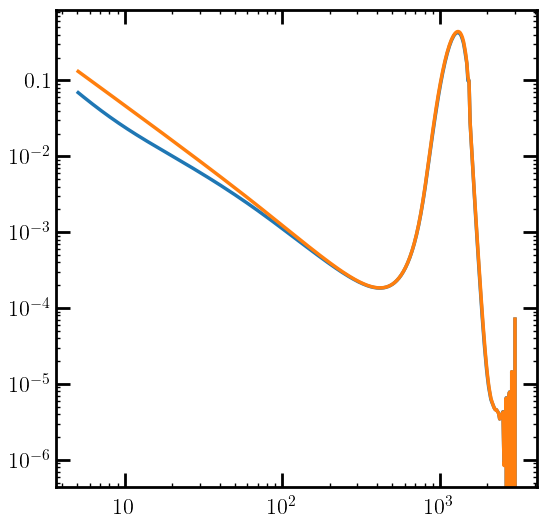

In [302]:
plt.figure()
plt.loglog()
plt.plot(DM_run_withf_withDf2['rs'], DM_run_withf_withDf2['distortions'].toteng())
plt.plot(DM_run_withf['rs'], DM_run_withf['distortions'].toteng())

In [812]:
import pickle

input_dir = '/Users/gregoryridgway/Dropbox (MIT)/DarkHistory_V2/data/'
input_dir = '/Users/gregoryridgway/Desktop/Data/'
data = pickle.load(open(input_dir+
                        'iter0_elec_decay_nmax100_endrs5_03_22.dat','rb'))  #_03_22

In [203]:
# spectra of lowengphots
ind = 5
tmp = data[1][ind]['lowengphot'].copy()

# mask out ionizing photons
mask = np.array(list(map(float,tmp.eng<13.6)))
tmp._grid_vals = tmp._grid_vals * mask

# redshift then sum
tmp.redshift(1.)
tmp = tmp.sum_specs()

Text(0, 0.5, 'Intensity, $I_{\\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]')

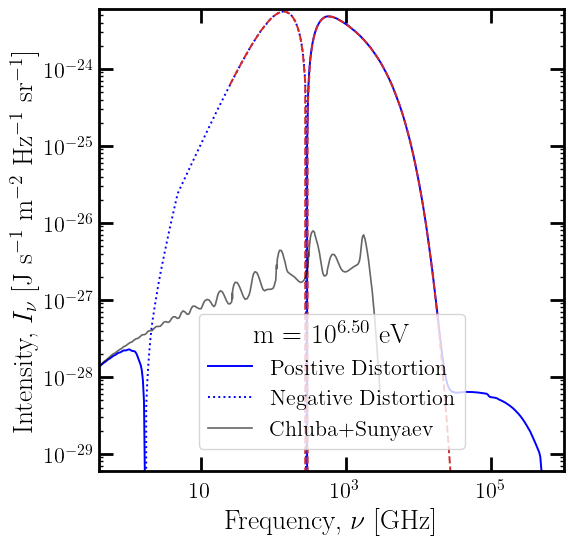

In [208]:
eng = baseline['distortion'].eng

hplanck = phys.hbar * 2*np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck
rs_fac = 1300


plt.figure(figsize=(6,6))
plt.loglog()
plt.xlim([4e-1, 1e6])
plt.ylim([6e-30, 6e-24])

# DH generated data
# plt.plot(nu/1e9, convert * baseline['distortion'].dNdE,
#          color='C0', linewidth=1.4, label='no DM')
# plt.plot(nu/1e9, convert * DMrun['distortion'].dNdE,
#          color='blue', linewidth=1.4, label='w/ DM, (+)')
# plt.plot(nu/1e9, -convert * DM_run['distortion'].dNdE,
#          color='red', linewidth=1.4, label='w/ DM, (-)')

plt.plot(nu/1e9, convert * data[1][ind]['distortion'].dNdE,
         color=(0,0,1), linewidth=1.4, label='Positive Distortion')
plt.plot(nu/1e9, -convert * data[1][ind]['distortion'].dNdE,
         color='blue', linestyle=':', linewidth=1.4, label='Negative Distortion')

plt.plot(tmp.eng/hplanck/1e9, phys.nB * tmp.eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4 * tmp.dNdE,
         color='C3', linestyle='--', linewidth=1.4)
plt.plot(tmp.eng/hplanck/1e9, -phys.nB * tmp.eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4 * tmp.dNdE,
         color='C3', linestyle='--', linewidth=1.4)


# Data from Jens Chluba et al's papers
plt.plot(BB_BF_jens[:,0], BB_BF_jens[:,1], color='k',
         linewidth=1.2, label='Chluba+Sunyaev', alpha=0.6)
# plt.plot(n10_data[:,0], n10_data[:,1], color='k',
#          linewidth=2.0, linestyle='--', label='Jens+')
# plt.plot(n20_data[:,0], n20_data[:,1], color='k', linewidth=1.0, linestyle=':')
# plt.plot(n30_data[:,0], n30_data[:,1], color='k', linewidth=1.2)
# plt.plot(jens_data[:,0], jens_data[:,1], color='k', linewidth=2.0, linestyle='--')

string = '{:.2f}'.format(np.log10(data[0][ind][0]))
string = r'm = $10^{'+string+'}$ eV'
plt.legend(title=string)

plt.xlabel(r'Frequency, $\nu$ [GHz]', fontsize=20)
plt.ylabel(r'Intensity, $I_{\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)

In [822]:
tmp = [data[0].flatten(), []]

for d in data[1]:
    tmp[1].append(d['distortion'])
    
pickle.dump(tmp, open('/Users/gregoryridgway/Dropbox (MIT)/DarkHistory_V2/data/iter0_elec_decay_nmax100_endrs5_03_22.dat', 'wb'))

In [825]:
data[1]

array([{'rs': array([3000.        , 2997.0014995 , 2994.005996  , ...,    5.01466975,
                 5.00965759,    5.00465044]), 'x': array([[9.99999999e-01, 8.10359844e-02],
              [9.99999999e-01, 7.88565876e-02],
              [9.99999999e-01, 7.88535031e-02],
              ...,
              [3.31290179e-02, 5.43939893e-14],
              [3.31628681e-02, 5.43939893e-14],
              [3.31967532e-02, 5.43939893e-14]]), 'Tm': array([0.70459625, 0.70389201, 0.70318847, ..., 0.16906369, 0.16931439,
              0.1695655 ]), 'highengphot': <darkhistory.spec.spectra.Spectra object at 0x149c2ed30>, 'lowengphot': <darkhistory.spec.spectra.Spectra object at 0x14f26f040>, 'lowengelec': <darkhistory.spec.spectra.Spectra object at 0x14f26f7c0>, 'distortions': <darkhistory.spec.spectra.Spectra object at 0x149bfe100>, 'distortion': <darkhistory.spec.spectrum.Spectrum object at 0x149bfebb0>, 'f': {'H ion': array([2.40716786e-13, 2.01259954e-05, 4.91450425e-03, ...,
              2.

Text(0, 0.5, 'Intensity, $I_{\\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]')

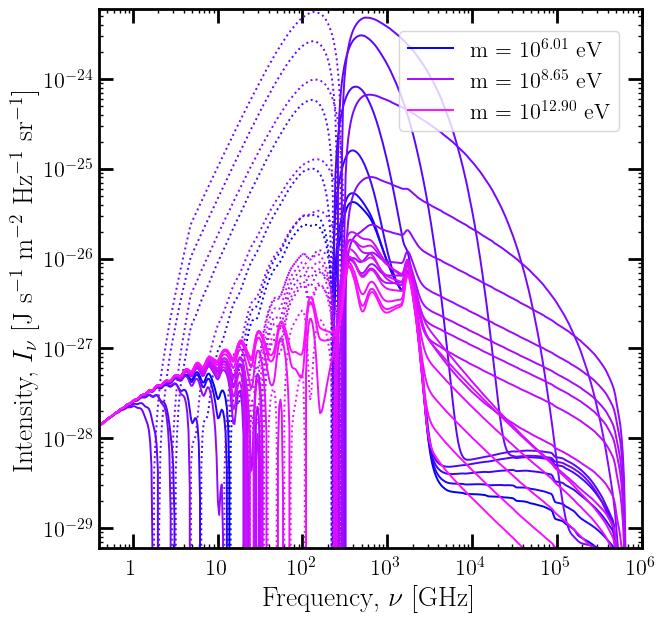

In [827]:
import pickle

input_dir = '/Users/gregoryridgway/Dropbox (MIT)/DarkHistory_V2/data/'
# input_dir = '/Users/gregoryridgway/Desktop/Data/'
data = pickle.load(open(input_dir+
                        'iter0_elec_decay_nmax100_endrs5_03_22.dat','rb'))  #_03_22

eng = data[1][0].eng

hplanck = phys.hbar * 2*np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck
rs_fac = 1300


plt.figure(figsize=(7, 7))
plt.loglog()
plt.xlim([4e-1, 1e6])
plt.ylim([6e-30, 6e-24])

# DH generated data

cs = np.linspace(0,1,len(data[0]))**0.66

for i in np.arange(len(data[0])):
    
    string = '{:.2f}'.format(np.log10(data[0][i]))
    string = r'm = $10^{'+string+'}$ eV'
    
    if i==0 or i==19 or i==10:
        plt.plot(nu/1e9, convert * data[1][i].dNdE,
                 color=(cs[i],cs[i]/15,1), linewidth=1.4, label=string)
    else:
        plt.plot(nu/1e9, convert * data[1][i].dNdE,
                 color=(cs[i],cs[i]/15,1), linewidth=1.4)
        
    plt.plot(nu/1e9, -convert * data[1][i].dNdE,
             color=(cs[i],cs[i]/15,1), linewidth=1.4, linestyle=':')

plt.legend()

plt.xlabel(r'Frequency, $\nu$ [GHz]', fontsize=20)
plt.ylabel(r'Intensity, $I_{\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)

Make sure this isn't coming from low energy photons.

In [170]:
1/phys.hubble(4)/(np.pi*1e7)/1e9

3.190496146330368

In [162]:
tau_bound_elec_CMB(5e6)

2.766300429473599e+24

In [ ]:
data[1][i]['distortions'].toteng()

6.013678810996636 10.646476617926604
6.021675273784309 10.715816751501887
6.044199314851133 11.119177843298438
6.103940160187505 14.092443410780149
6.242237103503343 31.944300903226235
6.496477552807342 91.37484634646543
6.8568684175901975 42.59095579284164
7.279337348227743 20.884583518226314
7.7287777518534595 15.876913993520763
8.188346916909495 12.750747859168726
8.651503224301859 11.783060938842521
9.115903072559847 11.337466320892712
9.58073079837503 11.05955213617763
10.045705368042224 10.655430960373762
10.510730288472578 10.52761330724029
10.975772468233327 10.433373330038625
11.440820563561855 10.318508343281117
11.905870686355396 10.208434482066705
12.370921504021188 10.160226743531343
12.9025360460621 10.142628378555656


Text(0, 0.5, 'Energy Injected into Distortion')

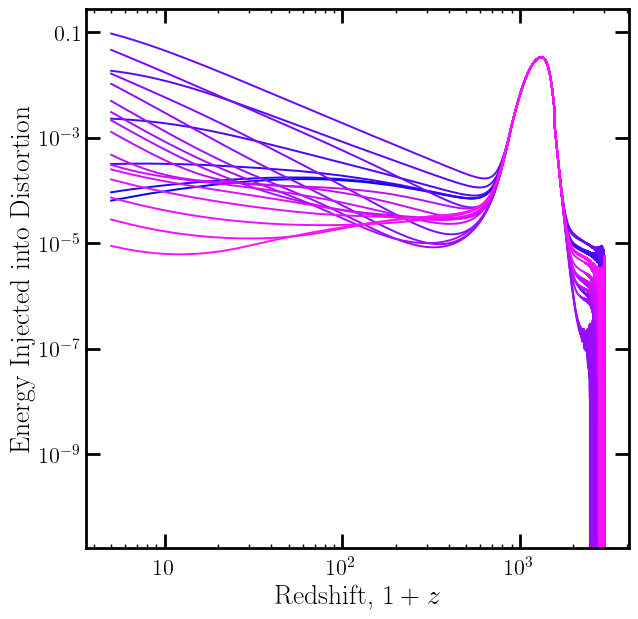

In [165]:
plt.figure(figsize=(7, 7))
plt.loglog()

cs = np.linspace(0,1,len(data[0]))**0.66


for i in np.arange(len(data[0])):
    print(np.log10(data[0][i][0]), sum(data[1][i]['distortions'].toteng()))
    plt.plot(data[1][i]['rs'], data[1][i]['distortions'].toteng(),
             color=(cs[i],cs[i]/15,1), linewidth=1.4)

# plt.legend(loc=2)

plt.xlabel(r'Redshift, $1+z$', fontsize=20)
plt.ylabel(r'Energy Injected into Distortion', fontsize=20)

In [ ]:
fig, axarr = plt.subplots(1,2, figsize=(14, 7))
axarr[0].loglog()
axarr[0].set_ylim([1e-22, 1e-8])

axarr[0].plot(DMrun_withf['rs'], DMrun_withf['MLA'][0][1:], label=r'$\alpha$, no $f_{exc}$')
axarr[0].plot(DMrun_withf['rs'], DMrun_withf['MLA'][1][1:], label=r'$\beta$, no $f_{exc}$')

axarr[0].plot(DMrun['rs'], DMrun['MLA'][0][1:], label=r'$\alpha$, w/ $f_{exc}$')
axarr[0].plot(DMrun['rs'], DMrun['MLA'][1][1:], label=r'$\beta$, w/ $f_{exc}$')

# axarr[0].plot(DM_run0['rs'], phys.alpha_recomb(Tm_vec, 'HI') + 0*xe_vec**2*nH_vec)
# rate = phys.beta_ion(Tr_vec, 'HI') * x2_vec
# axarr[0].plot(DM_run0['rs'], rate)

axarr[0].set_xlabel('Redshift, $1+z$')
axarr[0].set_ylabel('Recombination/Ionization Rates, [$s^{-1}$]')
axarr[0].legend()

# plt.plot(DM_run_withf0['rs'], np.abs(DM_run_withf0['MLA'][0][1:]/DM_run0['MLA'][0][1:]-1),
#          label=r'$\alpha$')


axarr[1].loglog()
axarr[1].set_ylim([1e-3, 1])
axarr[1].plot(DMrun_withf['rs'], DMrun_withf['MLA'][1][1:]/DMrun['MLA'][1][1:]-1,
         label=r'$\Delta \beta$')

axarr[1].axvline(600, linestyle='--', color='k', label=r'$1+z=600$')

axarr[1].legend()
axarr[1].set_xlabel('Redshift, $1+z$')
axarr[1].set_ylabel('Fractional Difference in Ionization Rate')

In [140]:
mDM = data[0][ind][0]

MLA_funcs = np.array([
    interp1d(data[1][ind]['rs'], data[1][ind]['MLA'][0][1:]),
    interp1d(np.log(data[1][ind]['rs']), np.log(data[1][ind]['MLA'][1][1:]))
])

f_raw = {key: interp1d(data[1][ind]['rs'], data[1][ind]['f'][key],
                       bounds_error=False, fill_value = (0,0))
         for key in data[1][ind]['f'].keys()}

def f_H_ion(rs, xHI, xHeI, xHeII):
    return f_raw['H ion'](rs)
def f_heat(rs, xHI, xHeI, xHeII):
    return f_raw['heat'](rs)
def f_H_exc(rs, xHI, xHeI, xHeII):
    return f_raw['Lya'](rs)

def rate_func_eng(rs):
    return phys.inj_rate(DM_process, rs, mDM=mDM, lifetime=tau_bound_elec_CMB(mDM))

rs_vec = np.exp(np.arange(np.log(3e3),np.log(5.4),-.001))

iterated = tla.get_history(
    rs_vec, high_rs=np.inf,
    f_H_ion=f_H_ion, f_H_exc=f_H_exc, f_heating=f_heat,
    injection_rate=rate_func_eng,
    recfast_TLA=False,
    alpha_MLA=MLA_funcs[0], beta_MLA=MLA_funcs[1],
    mxstep=10000, rtol=1e-8
)

/var/folders/kq/gkzlnb6576x8mxsf32v72_y00000gn/T/ipykernel_22424/3134640582.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ind in tqdm(np.arange(len(data[0]))):


  0%|          | 0/20 [00:00<?, ?it/s]

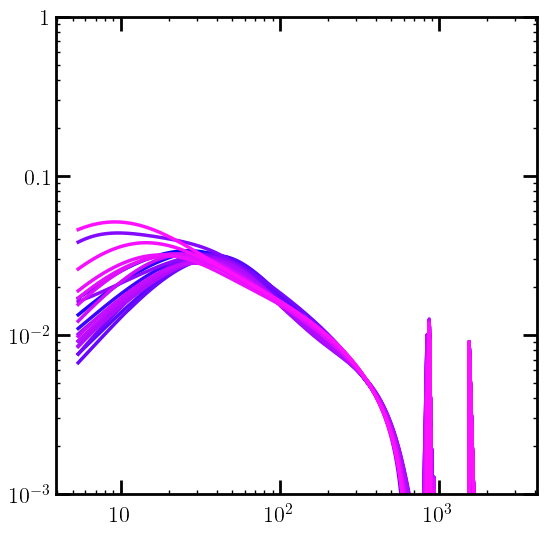

In [147]:
plt.figure()
plt.loglog()
plt.ylim([1e-3,1])

for ind in tqdm(np.arange(len(data[0]))):

    mDM = data[0][ind][0]

    MLA_funcs = np.array([
        interp1d(data[1][ind]['rs'], data[1][ind]['MLA'][0][1:]),
        interp1d(np.log(data[1][ind]['rs']), np.log(data[1][ind]['MLA'][1][1:]))
    ])

    f_raw = {key: interp1d(data[1][ind]['rs'], data[1][ind]['f'][key],
                           bounds_error=False, fill_value = (0,0))
             for key in data[1][ind]['f'].keys()}

    def f_H_ion(rs, xHI, xHeI, xHeII):
        return f_raw['H ion'](rs)
    def f_heat(rs, xHI, xHeI, xHeII):
        return f_raw['heat'](rs)
    def f_H_exc(rs, xHI, xHeI, xHeII):
        return f_raw['Lya'](rs)

    def rate_func_eng(rs):
        return phys.inj_rate(DM_process, rs, mDM=mDM, lifetime=tau_bound_elec_CMB(mDM))

    rs_vec = np.exp(np.arange(np.log(3e3),np.log(5.4),-.001))

    iterated = tla.get_history(
        rs_vec, high_rs=np.inf,
        f_H_ion=f_H_ion, f_H_exc=f_H_exc, f_heating=f_heat,
        injection_rate=rate_func_eng,
        recfast_TLA=False,
        alpha_MLA=MLA_funcs[0], beta_MLA=MLA_funcs[1],
        mxstep=10000, rtol=1e-8
    )

    plt.plot(rs_vec, iterated[:,1]/data[1][ind]['x'][:6320,0]-1,
            color=(cs[ind],cs[ind]/15,1))
# plt.plot(baseline['rs'], baseline['x'][:,0])
# plt.plot(rs_vec, iterated[:,1])
# plt.plot(rs_vec, iterated_withf[:,1])

TODO
- check the baseline scenario (no DM injection). See how much comes from difference between BB and truth, but also numerical precision (n=100 approx)
- one second iteration to show that the iteration procedure works
- Include reionization, make sure it's consistent with Planck's 2sigma region, see if dominant contribution comes from latest times (that we're not keeping track of)
- understand where the features come from

$\chi \to e^+ e^-$

In [772]:
tmp = pickle.load(open('/Users/gregoryridgway/Desktop/Data/'+
                            'iter0_elec_swave_nmax10_endrs5.dat','rb'))

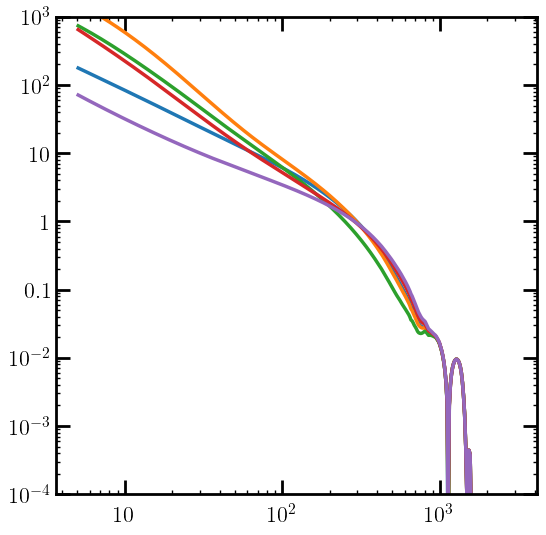

In [773]:
f, axarr = plt.subplots(1,2,figsize=(10,5))
axarr[1].loglog()
plt.ylim([1e-4,1000])
for i in np.arange(5):
#     plt.plot(tmp[1][i]['rs'], tmp[1][i]['distortions'].toteng())
    axarr[1].plot(tmp[1][i]['rs'], np.abs(
        tmp[1][i]['x'][:,0]/phys.xHII_std(tmp[1][i]['rs'])-1))

In [198]:
baseline = pickle.load(open('/Users/gregoryridgway/Desktop/Data/'+
                            'baseline_elec_decay_nmax20_endrs900.dat','rb'))

# goods = pickle.load(open('/Users/gregoryridgway/Desktop/Data/'+
#                             'iter0_phot_decay_nmax10_endrs5.dat','rb'))
# sum(np.isnan(baseline[1][0]['distortions'].toteng()))

Text(0.5, 1.0, 'rs = 1798')

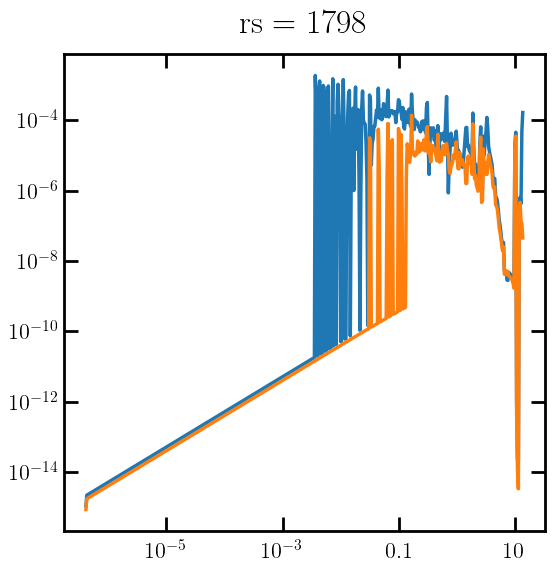

In [214]:
plt.figure()
plt.loglog()
ind = 32
plt.plot(baseline[1][0]['distortions'][ind].eng, np.abs(baseline[1][0]['distortions'][ind].dNdE))
plt.plot(baseline2[1][0]['distortions'][ind].eng, np.abs(baseline2[1][0]['distortions'][ind].dNdE))
plt.title('rs = '+str(round(baseline[1][0]['distortions'][ind].rs)))

In [318]:
nmax = 100
cf = 16

input_str = 'n'+str(nmax)+'cf'+str(cf)

data[input_str] = main.evolve(
    DM_process='decay', mDM=10**6.01,
    lifetime=2.7e24 * 1e20,
    primary='elec_delta',
    start_rs = 3e3, high_rs = 1.555e3, end_rs=5,
    coarsen_factor=cf, backreaction=True,
    distort=True,
    nmax=nmax,
    recfast_TLA=True,
    # MLA_funcs=MLA_funcs, 
    fexc_switch = True, reprocess_distortion=False,
    cross_check=False
)

  0%|          | 0/400.0 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)


KeyboardInterrupt: 

In [293]:
inputs = [(15,16), (10,16), (15,8), (20,8), (20,4)]

In [280]:
inputs = [(15,16), (10,16), (15,8)]
for pair in inputs:
    nmax = pair[0]
    cf = pair[1]
    
    input_str = 'n'+str(nmax)+'cf'+str(cf)
    
    data[input_str] = main.evolve(
        DM_process='decay', mDM=10**6.01,
        lifetime=2.7e24 * 1e20,
        primary='elec_delta',
        start_rs = 3e3, high_rs = 1.555e3, end_rs=1100,
        coarsen_factor=cf, backreaction=True,
        distort=True,
        nmax=nmax,
        recfast_TLA=True,
        # MLA_funcs=MLA_funcs, 
        fexc_switch = True, reprocess_distortion=True,
        cross_check=False
    )

  0%|          | 0/126.0 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)


Text(0.5, 0, 'Redshift, $1+z$')

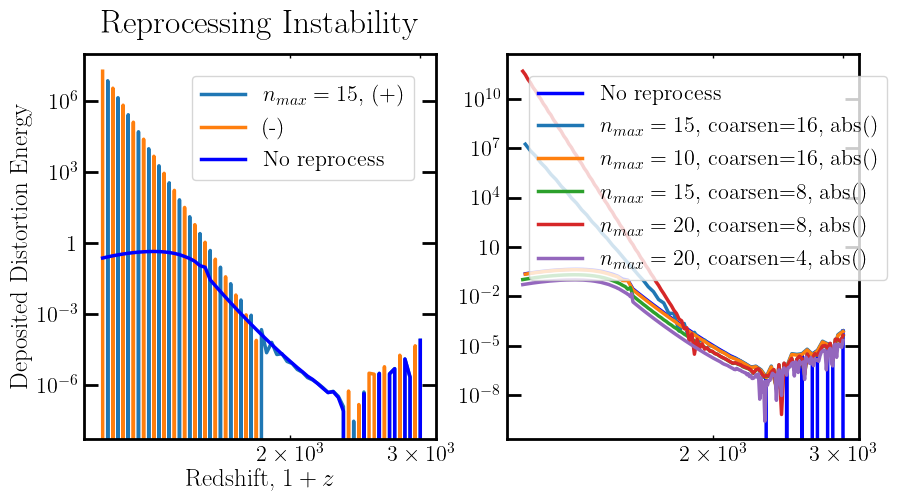

In [294]:
f, axarr = plt.subplots(1,2, figsize=(10,5), sharex=True)

# first plot
axarr[0].loglog()
axarr[0].plot(data['n15cf16']['rs'], data['n15cf16']['distortions'].toteng(),
         label='$n_{max}=15$, (+)')
axarr[0].plot(data['n15cf16']['rs'], -data['n15cf16']['distortions'].toteng(),
         label='(-)')
axarr[0].plot(data['stable']['rs'], data['stable']['distortions'].toteng(),
         label='No reprocess', color='blue')


# second plot
axarr[1].loglog()

axarr[1].plot(data['stable']['rs'], data['stable']['distortions'].toteng(),
         label='No reprocess', color='blue')

for pair in inputs:
    s = 'n'+str(pair[0])+'cf'+str(pair[1])

    axarr[1].plot(data[s]['rs'], np.abs(data[s]['distortions'].toteng()),
             label='$n_{max}='+str(pair[0])+'$, coarsen='+str(pair[1])+', abs()')
    
axarr[1].legend()

axarr[0].legend()
axarr[0].set_title('Reprocessing Instability')
axarr[0].set_ylabel('Deposited Distortion Energy')
axarr[0].set_xlabel('Redshift, $1+z$')

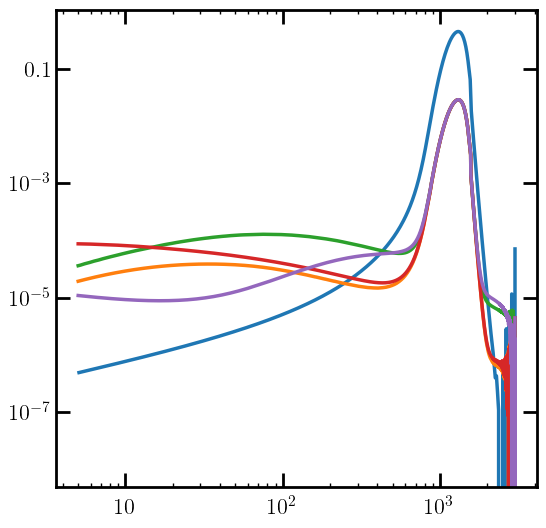

In [27]:
plt.figure()
plt.loglog()
# plt.plot(baseline[1][0]['rs'], baseline[1][0]['distortions'].toteng())
for i in np.arange(4):
    plt.plot(goods[1][i]['rs'], goods[1][i]['distortions'].toteng())

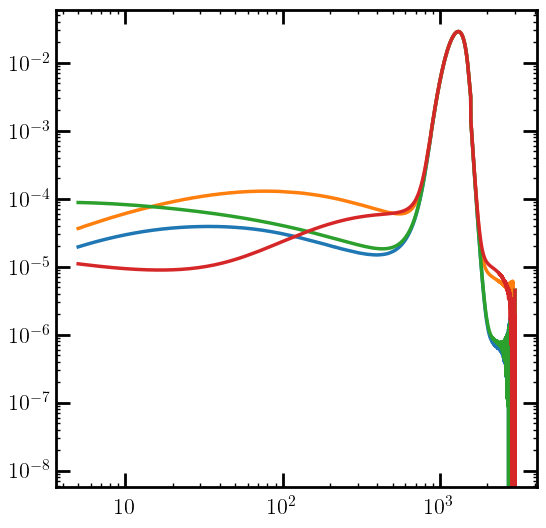

In [28]:
plt.figure()
plt.loglog()
# plt.plot(baseline[1][0]['rs'], baseline[1][0]['distortions'].toteng())
for i in np.arange(4):
    plt.plot(goods[1][i]['rs'], goods[1][i]['distortions'].toteng())

In [196]:
junk = main.evolve(
    DM_process='decay', mDM=10**6.013678810996636,
    lifetime=2.69747957975171e24 * 1e20,
    primary='elec_delta',
    start_rs = 3e3, high_rs = 1.555e3, end_rs=1100,
    coarsen_factor=8, backreaction=True,
    distort=True,
    nmax=10,
    recfast_TLA=True,
    # MLA_funcs=MLA_funcs, 
    fexc_switch = True, reprocess_distortion=True,
    cross_check=False
)

  0%|          | 0/126.0 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)


$$
T_e = T_\gamma \left(1 - \frac1J \right) + \dot{T}^{inj}_m/(JH)
$$

In [1040]:
%autoreload
tmp0 = main.evolve(
    DM_process='decay', mDM=10**6.01,
    lifetime=2.7e24,
    primary='elec_delta',
    start_rs = 3e3, high_rs = 1.555e3, end_rs=5,
    coarsen_factor=cf, backreaction=True,
    distort=True,
    nmax=20,
    recfast_TLA=True,
    # MLA_funcs=MLA_funcs, 
    fexc_switch = True, reprocess_distortion=False,
    cross_check=False
)

  0%|          | 0/400.0 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:477: RuntimeWarning: overflow encountered in true_divide
  K[nl, states_l == l+1] = BB['dn'][l+2:, n, l+1]/tot_rate
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:481: RuntimeWarning: overflow encountered in double_scalars
  K[0][1] = BB['dn'][2][1][0] / tot_rate
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHist

In [1164]:
%autoreload
tmp['noRE_noDM'] = main.evolve(
    DM_process='decay', mDM=10**6.01,
    lifetime=2.7e24*1e20,
    primary='elec_delta',
    start_rs = 2e3, high_rs = 1.555e3, end_rs=700,
    coarsen_factor=cf, backreaction=True,
    distort=True,
    nmax=20,
    recfast_TLA=True,
    # MLA_funcs=MLA_funcs, 
    fexc_switch = True, reprocess_distortion=True,
    cross_check=False
)

  0%|          | 0/66.0 [00:00<?, ?it/s]

[0. 0. 0. 0. 0.]
[-4.07454911e-10 -1.04000711e-11 -4.64432633e-12 -8.52093839e-12
 -1.24540570e-11]
[2.78268299e-06 6.37262542e-08 2.77638282e-08 4.98421729e-08
 7.30752039e-08]
[3.73316470e-06 8.16042348e-08 5.48314003e-08 8.80875725e-08
 7.47985563e-08]
[5.33070014e-06 1.10581863e-07 7.77877196e-08 1.21838807e-07
 9.94833779e-08]
[8.91481995e-06 1.71462749e-07 1.10412134e-07 1.52891598e-07
 1.51653289e-07]
[1.42991646e-05 2.50111008e-07 1.57671001e-07 2.29590380e-07
 2.06419246e-07]
[2.32758832e-05 3.76347909e-07 2.23647466e-07 3.29158361e-07
 2.96430239e-07]
[3.82858196e-05 5.69918789e-07 3.34808628e-07 4.68388477e-07
 4.28196113e-07]
[6.33821100e-05 8.69422784e-07 4.89463991e-07 6.88295162e-07
 6.19210647e-07]
[1.05843534e-04 1.33775632e-06 7.28509191e-07 1.00930133e-06
 9.05577533e-07]
[1.78062576e-04 2.07201378e-06 1.09373054e-06 1.49040758e-06
 1.33162207e-06]


KeyboardInterrupt: 

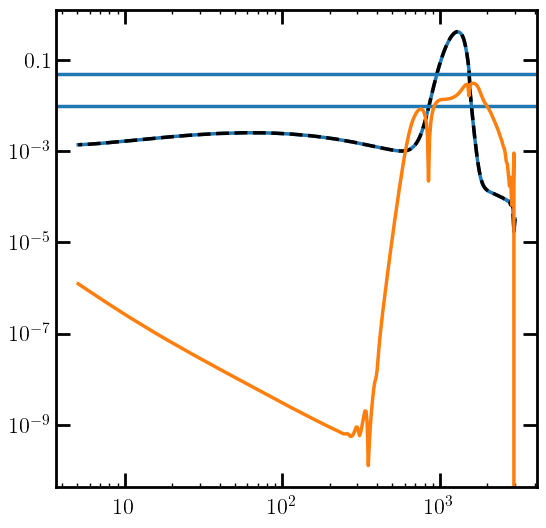

In [1047]:
plt.figure()
plt.loglog()
plt.plot(tmp2['rs'], tmp2['distortions'].toteng())
plt.plot(tmp0['rs'], tmp0['distortions'].toteng(), 'k--')
plt.axhline(.05)
plt.axhline(.01)

plt.plot(tmp['rs'], np.abs(tmp2['distortions'].toteng()/tmp0['distortions'].toteng()-1))
# plt.plot(tmp['rs'], np.abs(tmp['distortions'].toteng()/tmp0['distortions'].toteng()-1))

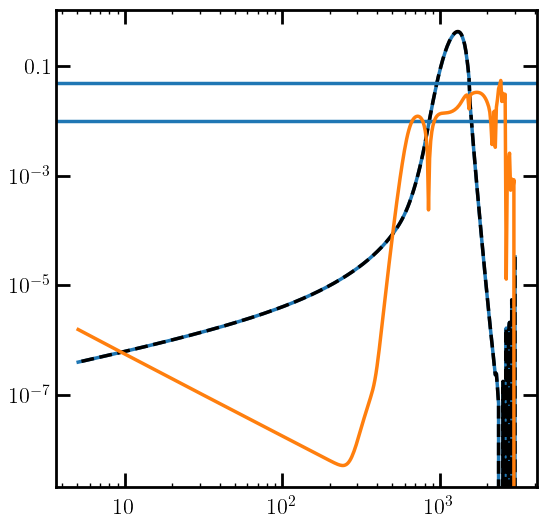

In [1051]:
plt.figure()
plt.loglog()
plt.plot(tmp['rs'], tmp['distortions'].toteng())
plt.plot(tmp1['rs'], tmp1['distortions'].toteng(), 'k--')
plt.axhline(.05)
plt.axhline(.01)

plt.plot(tmp['rs'], np.abs(tmp['distortions'].toteng()/tmp1['distortions'].toteng()-1))

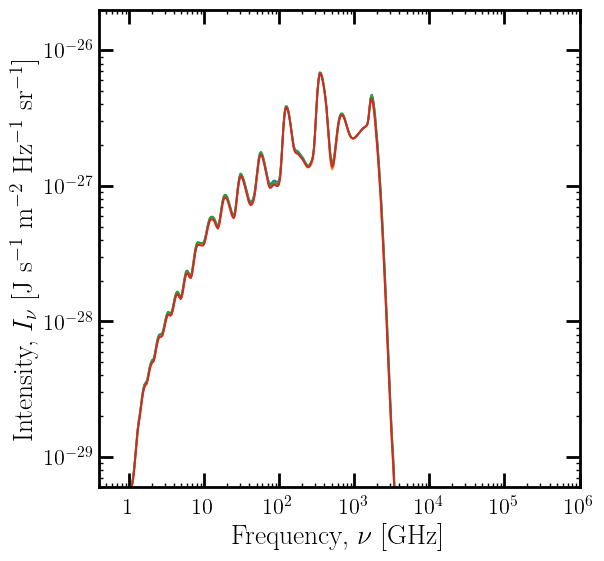

In [1091]:
plt.figure()
ax = plt.gca()

plot_distortion(ax, tmp['noRE_noDM'])
plot_distortion(ax, tmp['RE_noDM'])
plot_distortion(ax, tmp['noRE_DM'])
plot_distortion(ax, tmp['RE_DM'])

In [1115]:
tmp2['rs'][ind]

1148.6786579253342

Text(0.5, 1.0, 'Contribution at redshift 1044')

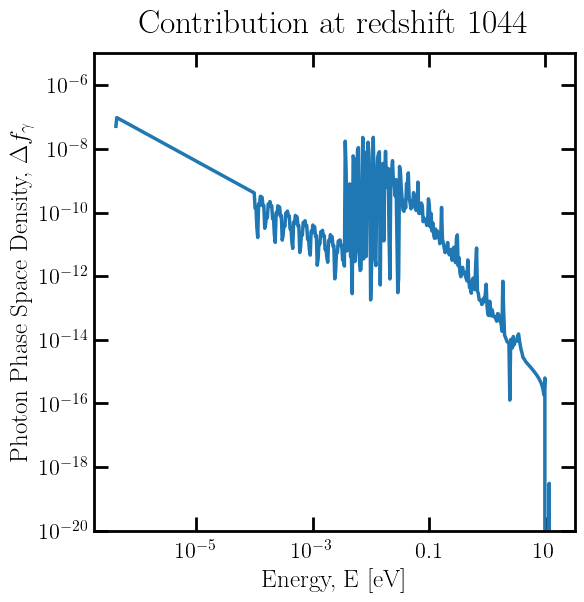

In [1124]:
plt.figure()
plt.loglog()

ind=66

# plt.plot(eng, tmp2['distortions'][ind].dNdE)
# plt.ylabel('dndE')

plt.ylim([1e-20, 1e-5])
plt.plot(eng, np.abs(prefac * tmp2['distortions'][ind].dNdE * tmp2['rs'][ind]**3))
plt.ylabel('Photon Phase Space Density, $\Delta f_{\gamma}$')

plt.xlabel('Energy, E [eV]')
plt.title('Contribution at redshift '+str(round(tmp2['rs'][ind])))

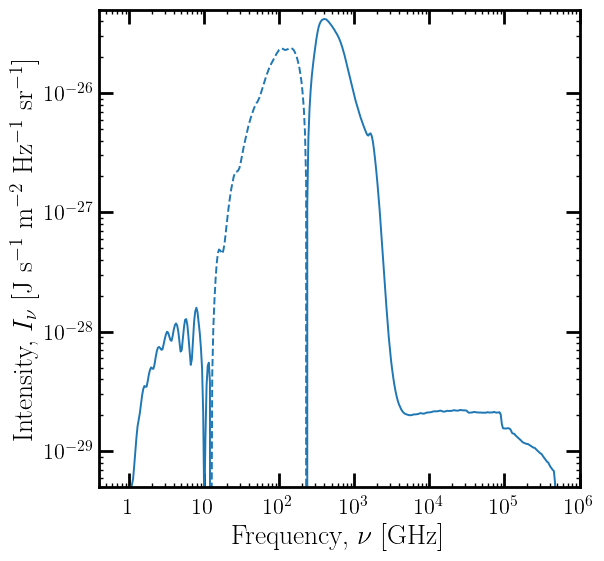

In [1099]:
plt.figure()
ax = plt.gca()
plot_distortion(ax, tmp2, ylim=[5e-30,5e-26])

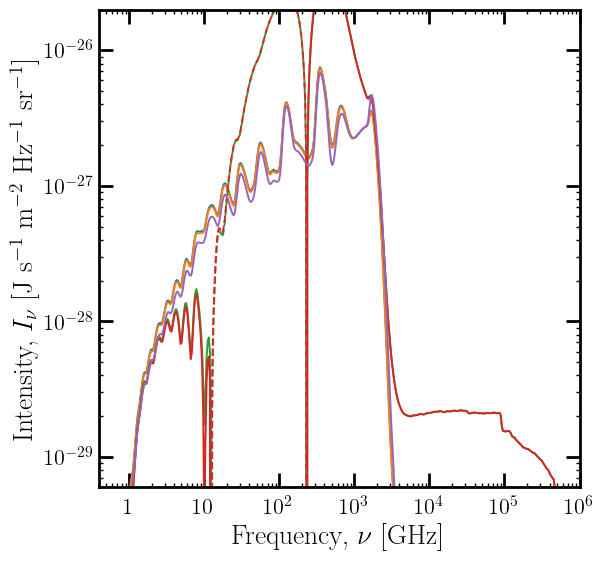

In [1078]:
plt.figure()
ax = plt.gca()

plot_distortion(ax, tmp1)  # not reprocessed, no DM
plot_distortion(ax, tmp)  # reprocessed, no DM
plot_distortion(ax, tmp0)  # not reprocessed, DM
plot_distortion(ax, tmp2)  # reprocessed, DM
plot_distortion(ax, tmp3)  # reprocessed, no DM, fixed mask

In [1054]:
nmax=100
run100_0 = main.evolve(
    DM_process='decay', mDM=10**6.01,
    lifetime=2.7e24*1e20,
    primary='elec_delta',
    start_rs = 2e3, high_rs = 1.555e3, end_rs=700,
    coarsen_factor=cf, backreaction=True,
    distort=True,
    nmax=nmax,
    recfast_TLA=True,
    # MLA_funcs=MLA_funcs, 
    fexc_switch = True, reprocess_distortion=False,
    cross_check=False
)

  0%|          | 0/66.0 [00:00<?, ?it/s]

In [1282]:
%autoreload
nmax=20
run100_2 = main.evolve(
    DM_process='decay', mDM=10**6.01,
    lifetime=2.7e24*1e20,
    primary='elec_delta',
    start_rs = 2e3, high_rs = 1.555e3, end_rs=700,
    coarsen_factor=cf, backreaction=True,
    distort=True,
    nmax=nmax,
    recfast_TLA=True,
    # MLA_funcs=MLA_funcs, 
    fexc_switch = True, reprocess_distortion=True,
    cross_check=False
)

  0%|          | 0/66.0 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.00000000e+00 9.94470821e-07 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.70873631e-08 1.22177628e-08
 2.27077087e-08 3.44675479e-08]
[0.00000000e+00 1.33415246e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.46865442e-08 2.41291309e-08
 4.01320171e-08 3.52804055e-08]
[0.00000000e+00 1.90507713e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.70037208e-08 3.42312992e-08
 5.55088187e-08 4.69235515e-08]
[0.00000000e+00 3.18596417e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 7.28816370e-08 4.85880139e-08
 6.96562303e-08 7.15306525e-08]
[0.00000000e+00 5.11021270e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.06311719e-07 6.93847720e-08
 1.04599602e-07 9.73622362e-08]
[0.00000000e+00 8.31829809e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.59969742e-07 9.84184051e-08
 1.49962005e-07 1.39817926e-07]
[0.00000000e

KeyboardInterrupt: 

In [1283]:
def download_plot(file):
    with open('/Users/gregoryridgway/Desktop/Webplot_distortion/'+file+'.csv') as csvfile:
        reader = csv.reader(csvfile)
        goods = []
        for row in reader:
            goods.append([float(r) for r in row])
            
        goods = np.array(goods)

    return goods

BB_BF_jens = download_plot('BB_plus_BF_dist')
n10_data = download_plot('n10')

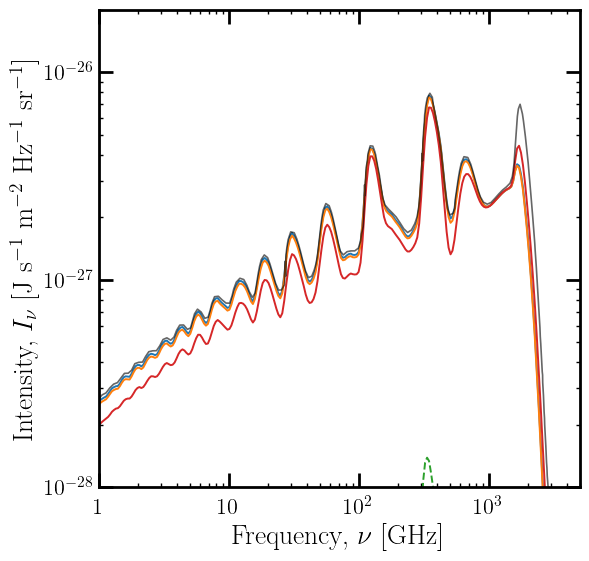

In [1281]:
plt.figure()
ax = plt.gca()

xlim = [1,5e3]
ylim = [1e-28, 2e-26]

plot_distortion(ax, run100_0, xlim=xlim, ylim=ylim)
plot_distortion(ax, run100_1, xlim=xlim, ylim=ylim)
plot_distortion(ax, run100_1, run100_0, diff=True, xlim=xlim, ylim=ylim)
plot_distortion(ax, run100_2, xlim=xlim, ylim=ylim)

plt.plot(BB_BF_jens[:,0], BB_BF_jens[:,1], color='k',
         linewidth=1.2, label='Chluba+Sunyaev', alpha=0.6)
# plot_distortion(ax, run100_1)

In [1471]:
nmax=100
R = atomic.populate_radial(nmax)

In [1476]:
%%prun

### !!! Vectorize
Tr = 0.7
ZEROTEMP=1e-10

BB = {key: np.zeros((nmax+1, nmax+1, nmax)) for key in ['up', 'dn']}
  
for n in np.arange(2, nmax+1):
    n2 = n**2
    for n_p in np.arange(1, n):
        n_p2 = n_p**2
        Ennp = (1/n_p2 - 1/n2) * phys.rydberg
        fEnnp = np.exp(-Ennp/Tr)/(1-np.exp(-Ennp/Tr))

        prefac = 2*np.pi/3 * phys.rydberg / hplanck * (
              phys.alpha * (1/n_p2 - 1/n2))**3

        for l in np.arange(0, n_p+1):  # Spont + stim emission
            A_up = prefac * (l+1) / (2*l+1) * R['up'][n][n_p][l]**2
            A_dn = prefac * l / (2*l+1) * R['dn'][n][n_p][l]**2
            BB['up'][n][n_p][l] = A_up * (1+fEnnp)
            BB['dn'][n][n_p][l] = A_dn * (1+fEnnp)

        BB['up'][n][n_p][n_p] = BB['up'][n][n_p][n_p-1] = 0.0   # No l'>=n'
        BB['dn'][n][n_p][0] = 0.0      
    
        for l in np.arange(0, n_p, 1):  # absorption: use detailed balance
            BB['up'][n_p][n][l] = (
              (2*l+3)/(2*l+1) *
              BB['dn'][n][n_p][l+1]/(1+fEnnp) * fEnnp)
            BB['dn'][n_p][n][l+1] = (
              (2*l+1)/(2*l+3) *
              BB['up'][n][n_p][l] / (1+fEnnp) * fEnnp)
  
    #Include forbidden 2s->1s transition
BB['dn'][2][1][0] = phys.width_2s1s_H
    #!!! What about the inverse process?

In [1485]:
%%prun
%autoreload
nmax=50  # 10
end_rs = 1.99e3  # 700
cf = 1. # 16

crap0 = main.evolve(
    DM_process='decay', mDM=10**6.01,
    lifetime=2.7e24*1e20,
    primary='elec_delta',
    start_rs = 2e3, high_rs = 1.555e3, end_rs=end_rs,
    coarsen_factor=cf, backreaction=True,
    distort=True,
    nmax=nmax,
    recfast_TLA=True,
    # MLA_funcs=MLA_funcs, 
    fexc_switch = True, reprocess_distortion=False,
    cross_check=False
)

  0%|          | 0/6.0 [00:00<?, ?it/s]

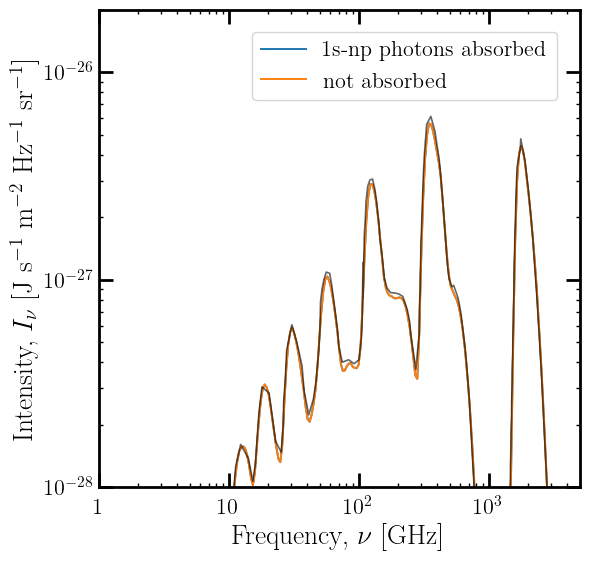

In [1378]:
plt.figure()
ax = plt.gca()

xlim = [1,5e3]
ylim = [1e-28, 2e-26]

plot_distortion(ax, crap0, xlim=xlim, ylim=ylim, label='1s-np photons absorbed', first=False)
plot_distortion(ax, crap, xlim=xlim, ylim=ylim, label='not absorbed', first=False)
plt.legend()

plt.plot(n10_data[:,0], n10_data[:,1], color='k',
         linewidth=1.2, label='Chluba+Sunyaev', alpha=0.6)

## Iterations at $n_{max}=100$

In [873]:
for i in np.arange(5):
    mDM = iter1[100][0][i]
    run = iter1[100][1][i]
    param = param_bound(mDM, DM_process, pri)

#     beta_func = interp1d(np.log(run['rs']), np.log(run['MLA'][1][1:]))
#     def beta_MLA(rs):
#         return np.exp(beta_func(np.log(rs)))

#     MLA_funcs = np.array([
#         interp1d(run['rs'], run['MLA'][0][1:]),
#         beta_MLA
#     ])

    f_raw = {key: interp1d(run['rs'], run['f'][key],
                           bounds_error=False, fill_value = (0,0))
             for key in run['f'].keys()}

    def f_H_ion(rs, xHI, xHeI, xHeII):
        return f_raw['H ion'](rs)
    def f_heat(rs, xHI, xHeI, xHeII):
        return f_raw['heat'](rs)
    def f_H_exc(rs, xHI, xHeI, xHeII):
        return f_raw['Lya'](rs)

    def rate_func_eng(rs):
        return phys.inj_rate(DM_process, rs, mDM=mDM, lifetime=param, sigmav=param)

#     rs_vec = np.exp(np.arange(np.log(3e3),np.log(5),-.001*16))

    out = tla.get_history(
        rs_list, high_rs=np.inf,
        f_H_ion=f_H_ion, f_H_exc=f_H_exc, f_heating=f_heat,
        injection_rate=rate_func_eng,
        recfast_TLA=True,
#         alpha_MLA=MLA_funcs[0], beta_MLA=MLA_funcs[1],
        mxstep=10000, rtol=1e-8
    )
    iter0.append(out[:,1])

In [871]:
iter0, iter1, iter2 = [], {}, {}

In [917]:
pri = 'elec'
DM_process = 'decay'

for nmax in [10,100]:
    iter1[nmax] = pickle.load(open('/Users/gregoryridgway/Desktop/Data/'+
        'iter1_'+pri+'_'+DM_process+'_nmax'+str(nmax)+'_endrs5.dat','rb'))

    iter2[nmax] = pickle.load(open('/Users/gregoryridgway/Desktop/Data/'+
        'iter2_'+pri+'_'+DM_process+'_nmax'+str(nmax)+'_endrs5.dat','rb'))
    
rs_list = iter1[100][1][i]['rs']

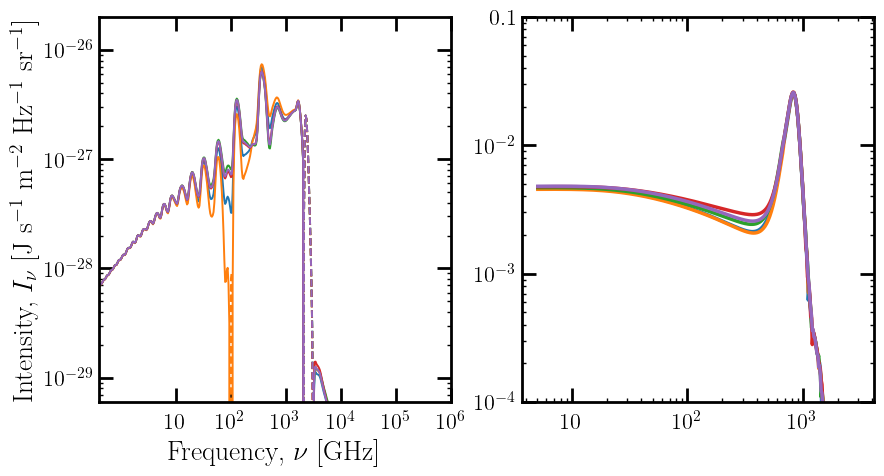

In [913]:
f, axarr = plt.subplots(1,2, figsize=(10,5))
axarr[0].loglog()
axarr[1].loglog()

axarr[1].set_ylim([1e-4,.1])

# i=0
for i in np.arange(5):
# axarr[0].plot(rs_list, iter0[i])
# axarr[0].plot(rs_list, iter1[100][1][i]['x'][:,0], ':')
# axarr[0].plot(rs_list, iter2[100][1][i]['x'][:,0], '--')
# axarr[0].plot(rs_list, phys.xHII_std(rs_list))

# axarr[0].plot(rs_list, np.abs(iter1[100][1][i]['x'][:,0]/iter0[i]-1))
# axarr[0].plot(rs_list, np.abs(iter2[100][1][i]['x'][:,0]/iter1[100][1][i]['x'][:,0]-1))
#     axarr[0].plot(iter1[10][1][i]['rs'], 
#                   np.abs(iter1[10][1][i]['x'][:,0]/iter0[10][1][i]['x'][:,0]-1),
#                  color='C'+str(i), linewidth=1.2, alpha=0.8, linestyle='--')

#     axarr[0].plot(rs_list, 
#                   np.abs(iter1[100][1][i]['x'][:,0]/iter0[i]-1),
#                  color='C'+str(i), linestyle=':')
    
    plot_distortion(axarr[0], iter1[100][1][i], diff=False)
#     plot_distortion(axarr[1], iter2[100][1][i], diff=False)
    
    axarr[1].plot(rs_vec, 
                  np.abs(iter2[100][1][i]['x'][:,0]/iter1[100][1][i]['x'][:,0]-1),
                 color='C'+str(i))